# Nettoyage des données

#### Gestion des imports

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannotations.Annotator import Annotator

#pip install jinja2 #Pour un plus joli rendu de graphe


#### Import des données et premières visualisations

In [41]:
df = pd.read_csv('4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv', sep=',')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [43]:
df.isnull().head()

,age,sex,bmi,children,smoker,region,charges
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False


In [44]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### Test de la librairie missingno

<Axes: >

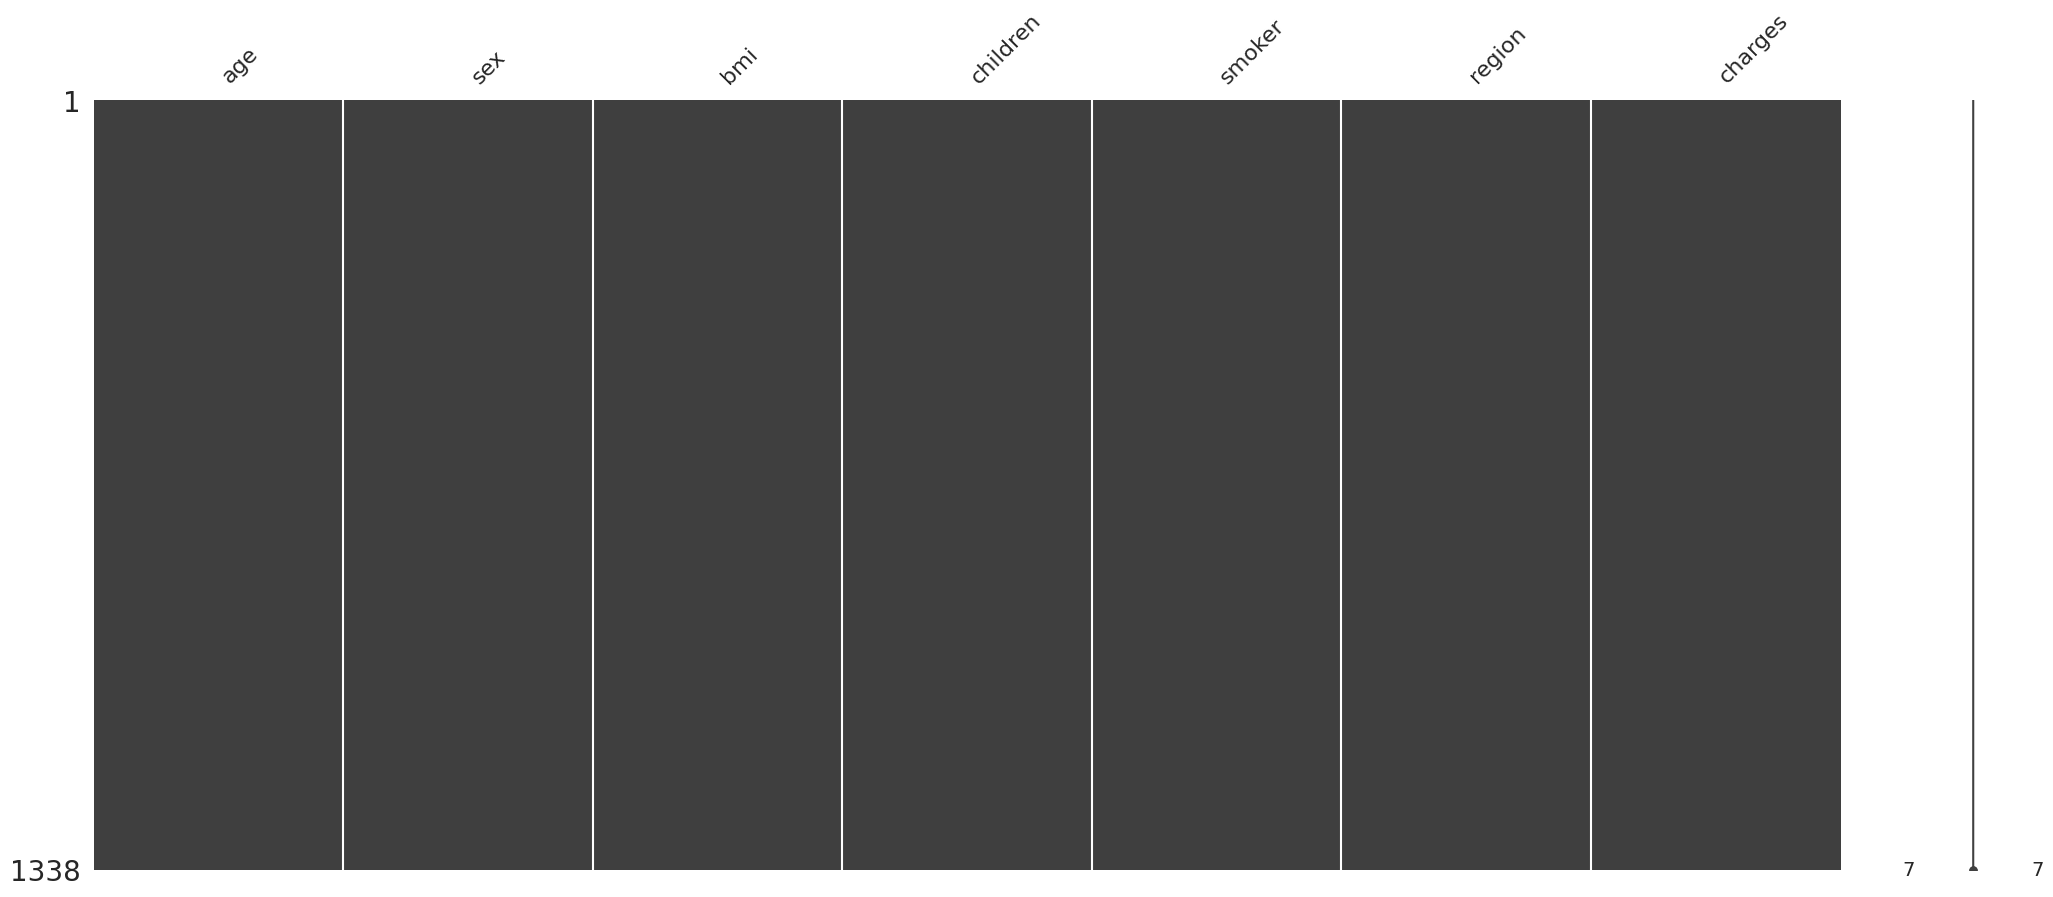

In [45]:
msno.matrix(df)

<Axes: >

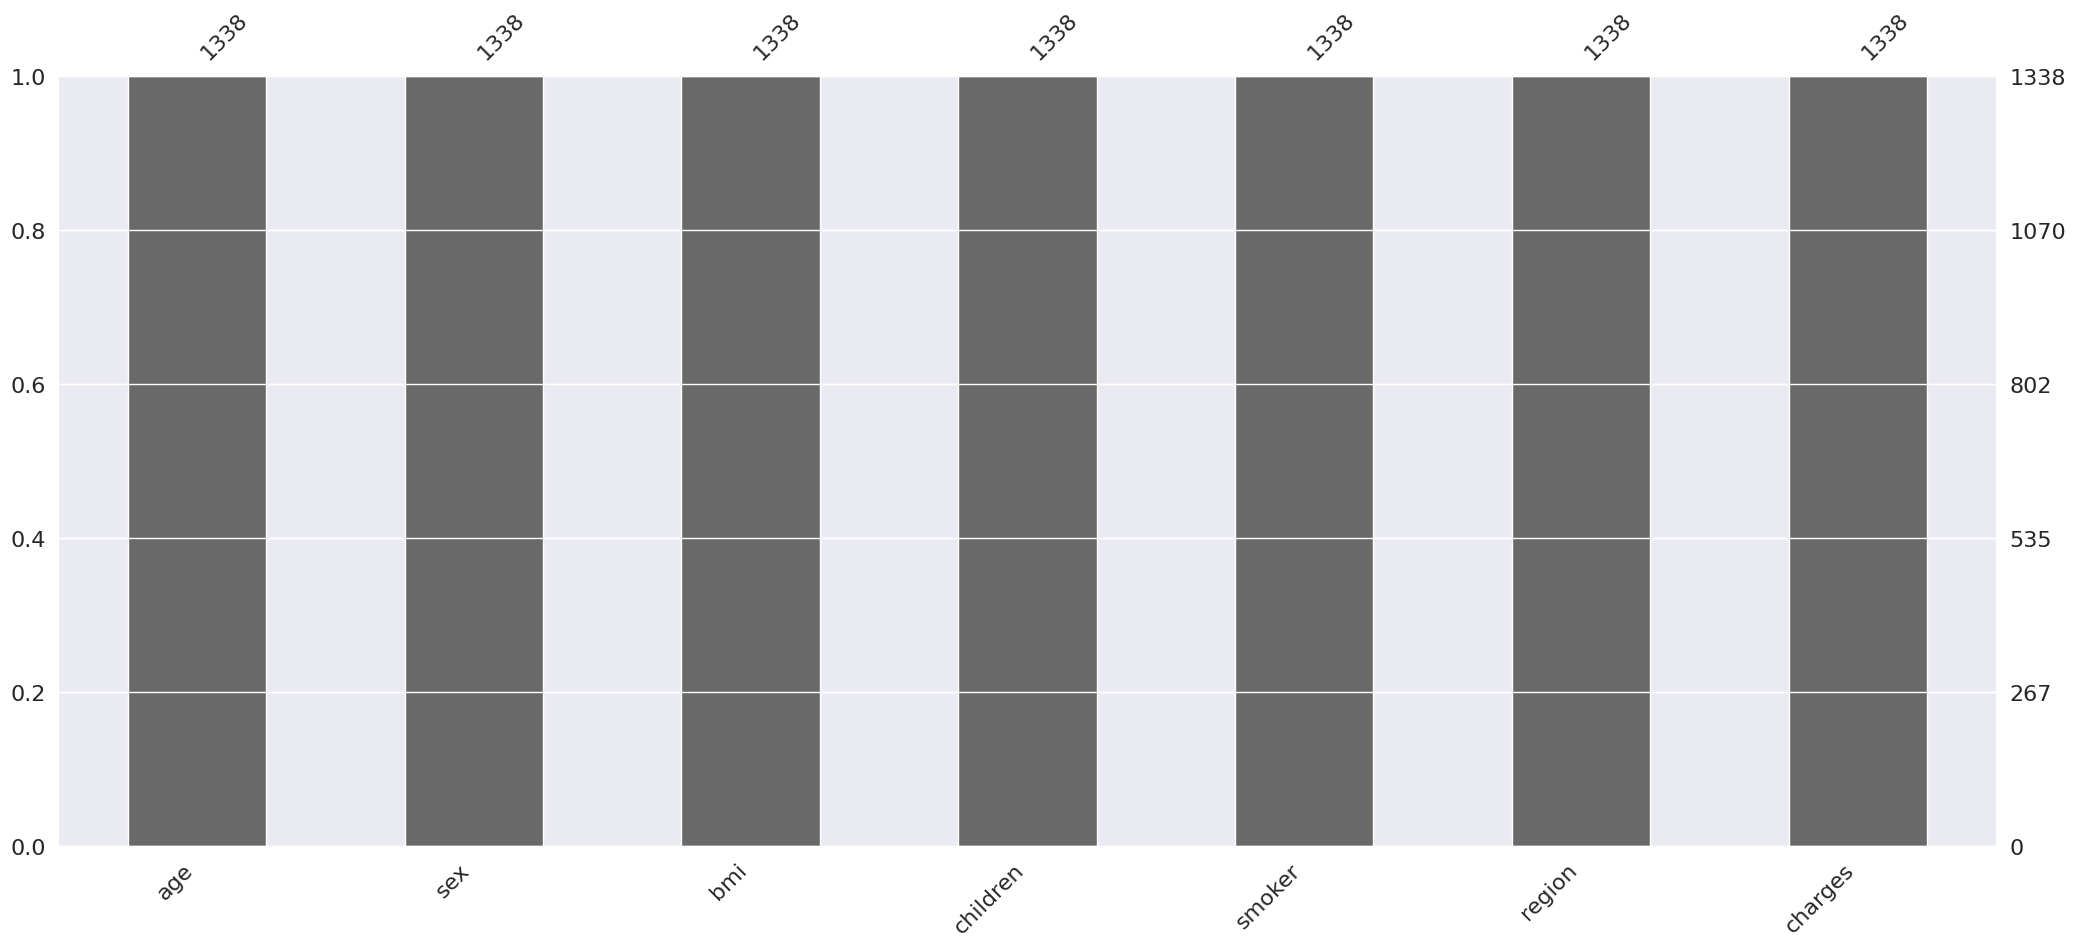

In [46]:
msno.bar(df)

/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

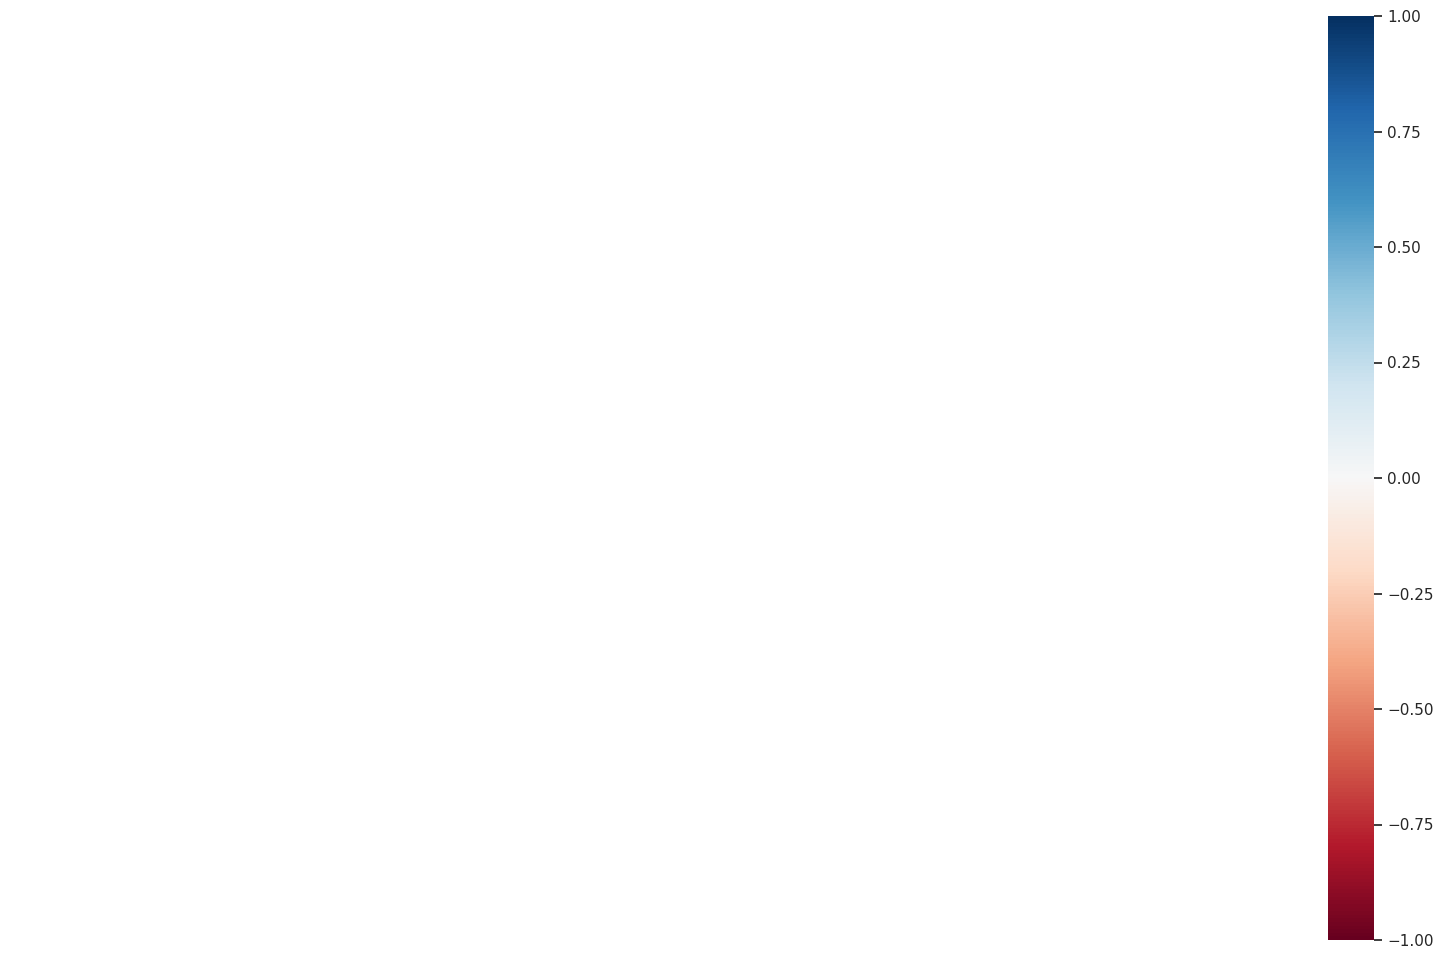

In [47]:
msno.heatmap(df)

Il semble qu'il n'y ait aucune donnée manquante dans ce dataset

#### Vérification des doublons

In [48]:
df.duplicated().count()
df.duplicated().sum()
df.duplicated().value_counts()

False    1337
True        1
Name: count, dtype: int64

In [49]:
df.drop_duplicates(inplace=True)
#le inplace =True permet de supprimer la ligne directement dans le df sans passer par del

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


Un unique doublon a été trouvé et supprimé

In [162]:
df.to_csv("cleansed_data.csv")

# Identification des valeurs aberrantes

In [51]:
df.shape[1]


7

In [52]:
def mean(x):
    mean_list=[]
    std_list=[]
    for i in range(0, x.shape[1]):
        mu=x.iloc[:,i].mean()
        mean_list.append(mu)
        std=x.iloc[:,i].std()
        std_list.append(std)
        return mean_list, std_list
mean(df)


([np.float64(39.222139117427076)], [np.float64(14.044332734156425)])

In [53]:
#IQR ou InterQuantile Range
def find_iqr(x):
  return np.subtract(*np.percentile(x, [75, 25]))

#calculate IQR for 'continue' columns
df[['charges', 'children', 'bmi', 'age']].apply(find_iqr)

# valeurs_aberantes = df[(df[colonne]<limite_inf) | (df[colonne]>limite_sup)]

charges     11911.37345
children        2.00000
bmi             8.41000
age            24.00000
dtype: float64

In [54]:
def find_outliers_iqr(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

columns = ['charges', 'children', 'bmi', 'age']

# Liste pour collecter les valeurs aberrantes
all_outliers = []

for i in columns:
    lower_bound, upper_bound = find_outliers_iqr(df[i])
    outliers = df[i][(df[i] < lower_bound) | (df[i] > upper_bound)]
    all_outliers.append(outliers)
    print(f"Valeurs aberrantes pour la colonne {i} :")
    print(outliers)

# Combiner toutes les valeurs aberrantes
all_outliers_combined = pd.concat(all_outliers)

# Compter les occurrences des valeurs aberrantes
outliers_counts = all_outliers_combined.value_counts()
print("\nFréquences des valeurs aberrantes :")
print(outliers_counts)


Valeurs aberrantes pour la colonne charges :
14      39611.75770
19      36837.46700
23      37701.87680
29      38711.00000
30      35585.57600
           ...     
1300    62592.87309
1301    46718.16325
1303    37829.72420
1313    36397.57600
1323    43896.37630
Name: charges, Length: 139, dtype: float64
Valeurs aberrantes pour la colonne children :
Series([], Name: children, dtype: int64)
Valeurs aberrantes pour la colonne bmi :
116     49.06
286     48.07
401     47.52
543     47.41
847     50.38
860     47.60
1047    52.58
1088    47.74
1317    53.13
Name: bmi, dtype: float64
Valeurs aberrantes pour la colonne age :
Series([], Name: age, dtype: int64)

Fréquences des valeurs aberrantes :
39611.7577    1
36837.4670    1
37701.8768    1
38711.0000    1
35585.5760    1
             ..
50.3800       1
47.6000       1
52.5800       1
47.7400       1
53.1300       1
Name: count, Length: 148, dtype: int64


Identification via le Z score

<Axes: xlabel='z_charges', ylabel='Count'>

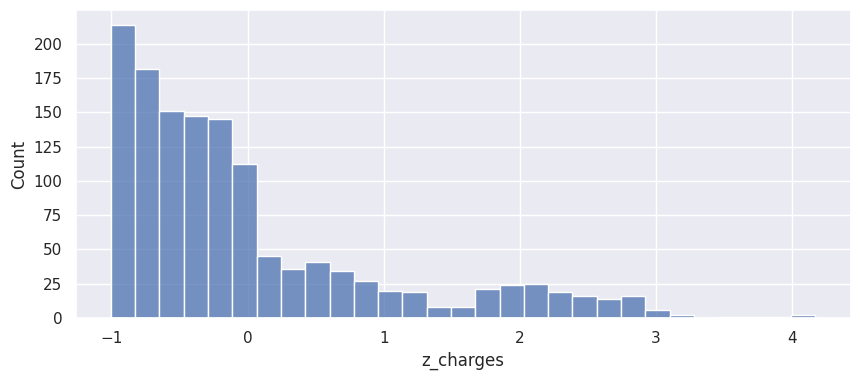

In [55]:
zscore =stats.zscore(df.charges)
zscore
df_zscore=pd.DataFrame(zscore, columns=['z_charges'])
df_zscore['z_age']=stats.zscore(df.age)
df_zscore['z_bmi']=stats.zscore(df.bmi)
df_zscore['z_children']=stats.zscore(df.children)
df_zscore
sns.histplot(x=df_zscore.z_charges)

Sur ce plot, ont une valeur supérieur à Z=3, qui sont donc considérés comme des outliers. Comptons ces valeurs

Number of outlier for z_charges: 7
Number of outlier for z_age: 0
Number of outlier for z_bmi: 4
Number of outlier for z_children: 18


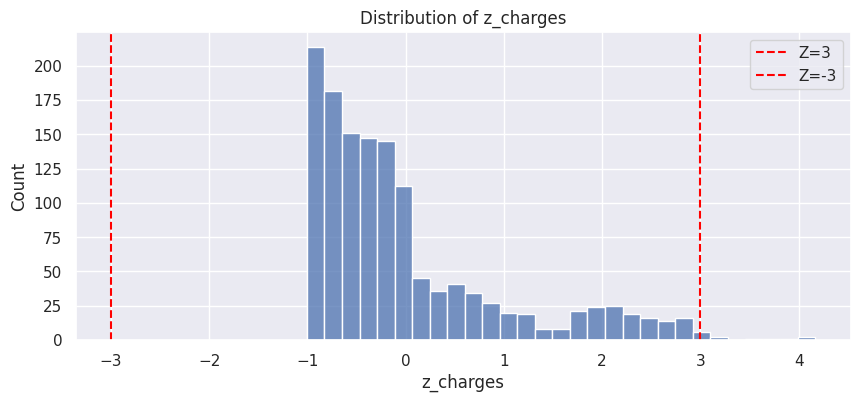

In [56]:
# Trouver les outliers :
outliers = {}
for col in df_zscore.columns:
    outliers[col] = df_zscore[df_zscore[col] > 3]

# Compter les outliers pour chaque colonne
outliers_count = {col: len(outliers[col]) for col in outliers}

# Afficher les résultats
for col, count in outliers_count.items():
    print(f"Number of outlier for {col}: {count}")

# Visualistion des outliers de z_charges
sns.histplot(x=df_zscore['z_charges'])
plt.axvline(3, color='red', linestyle='--', label='Z=3')
plt.axvline(-3, color='red', linestyle='--', label='Z=-3')
plt.legend()
plt.title('Distribution of z_charges')
plt.show()

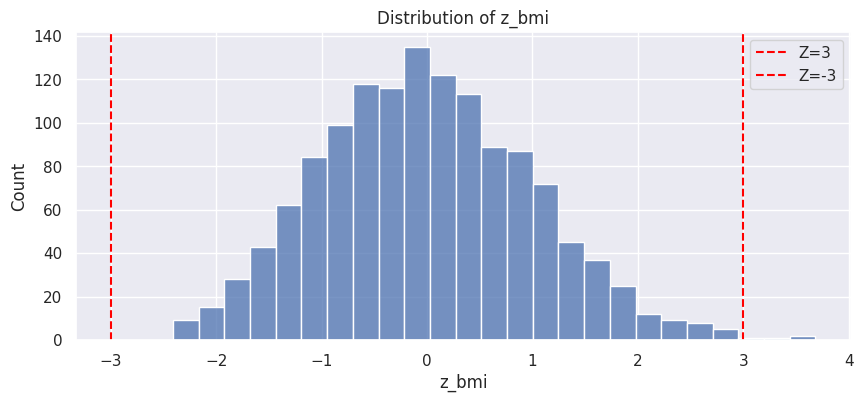

In [57]:
# Visualistion des outliers de z_bmi
sns.histplot(x=df_zscore['z_bmi'])
plt.axvline(3, color='red', linestyle='--', label='Z=3')
plt.axvline(-3, color='red', linestyle='--', label='Z=-3')
plt.legend()
plt.title('Distribution of z_bmi')
plt.show()

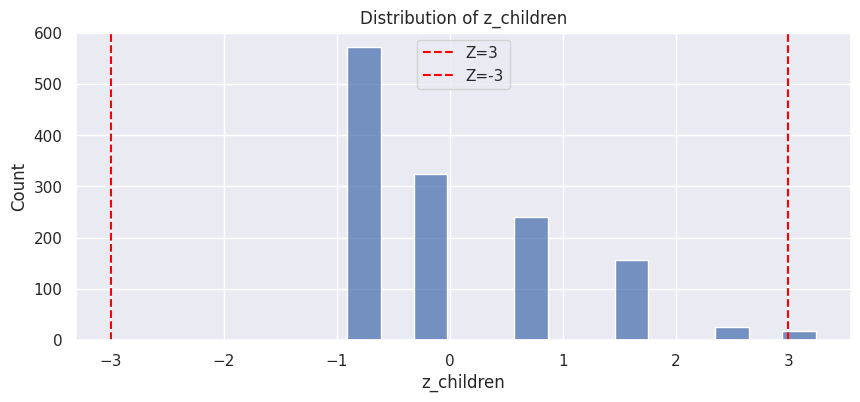

In [58]:
# Visualistion des outliers de z_children
sns.histplot(x=df_zscore['z_children'])
plt.axvline(3, color='red', linestyle='--', label='Z=3')
plt.axvline(-3, color='red', linestyle='--', label='Z=-3')
plt.legend()
plt.title('Distribution of z_children')
plt.show()

# Analyse univariée de chaque variables

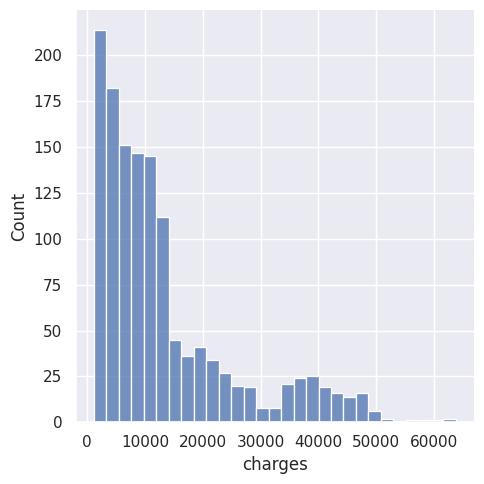

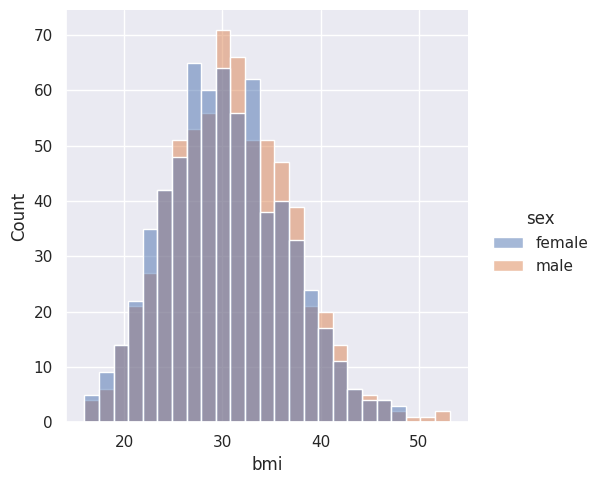

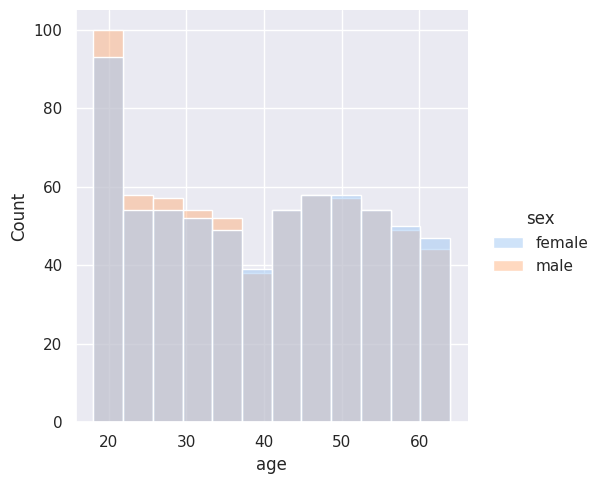

In [59]:
sns.displot(df, x="charges")
sns.displot(df, x="bmi", hue='sex')
sns.displot(df, x="age", hue='sex', palette='pastel')

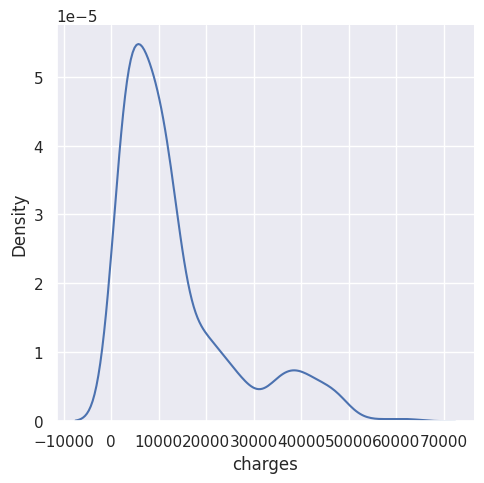

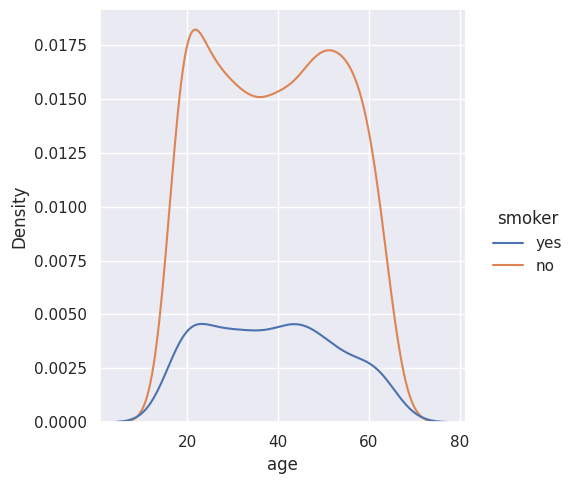

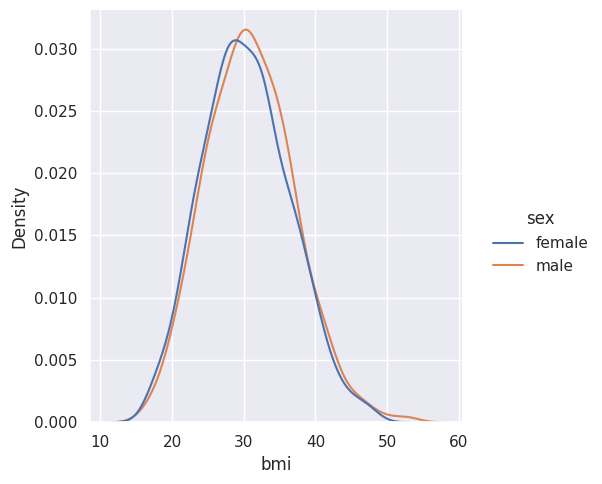

In [60]:
#Kernel density estimation
sns.displot(df, x="charges", kind="kde")
sns.displot(df,x="age", kind="kde", hue="smoker")
sns.displot(df, x="bmi", kind='kde', hue="sex")

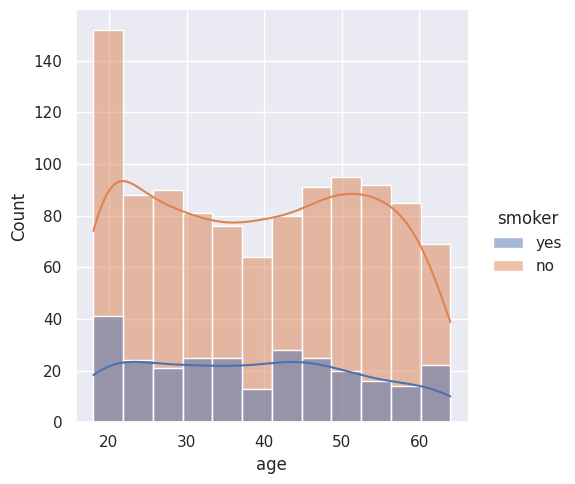

In [61]:
sns.displot(df,x="age", kde=True, hue="smoker")

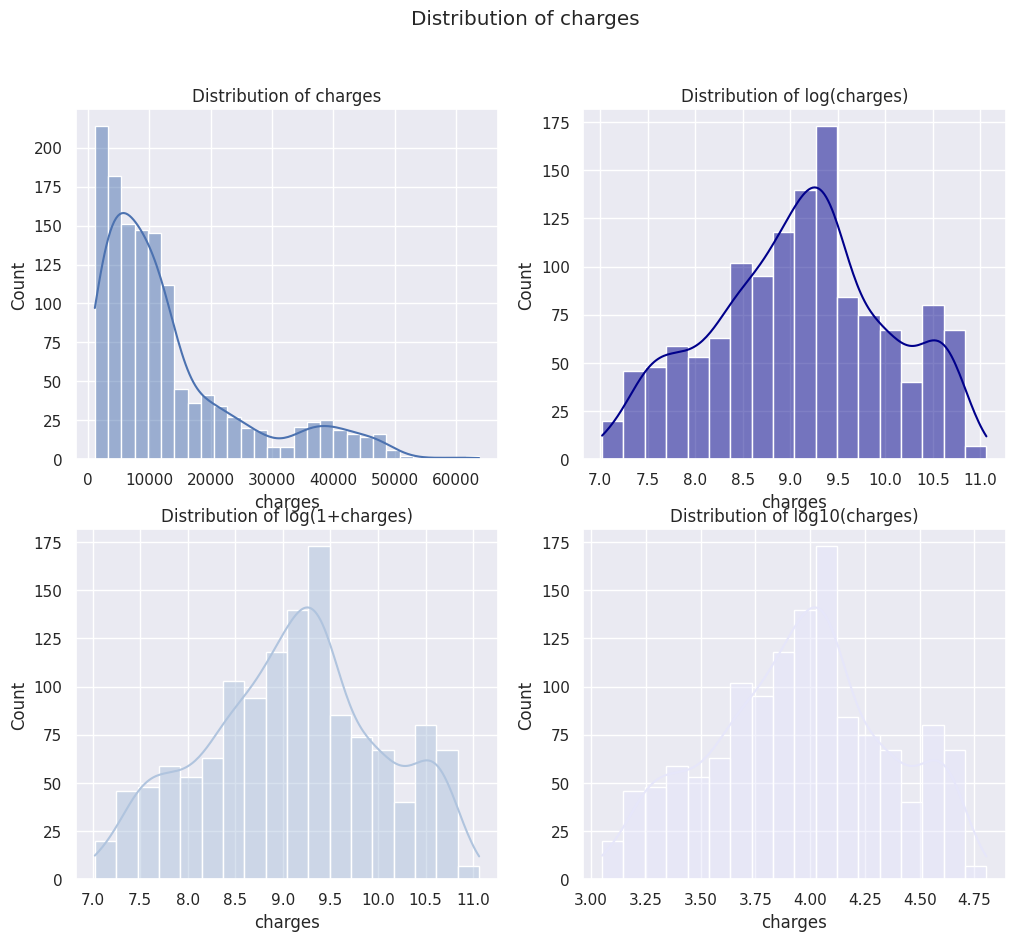

/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


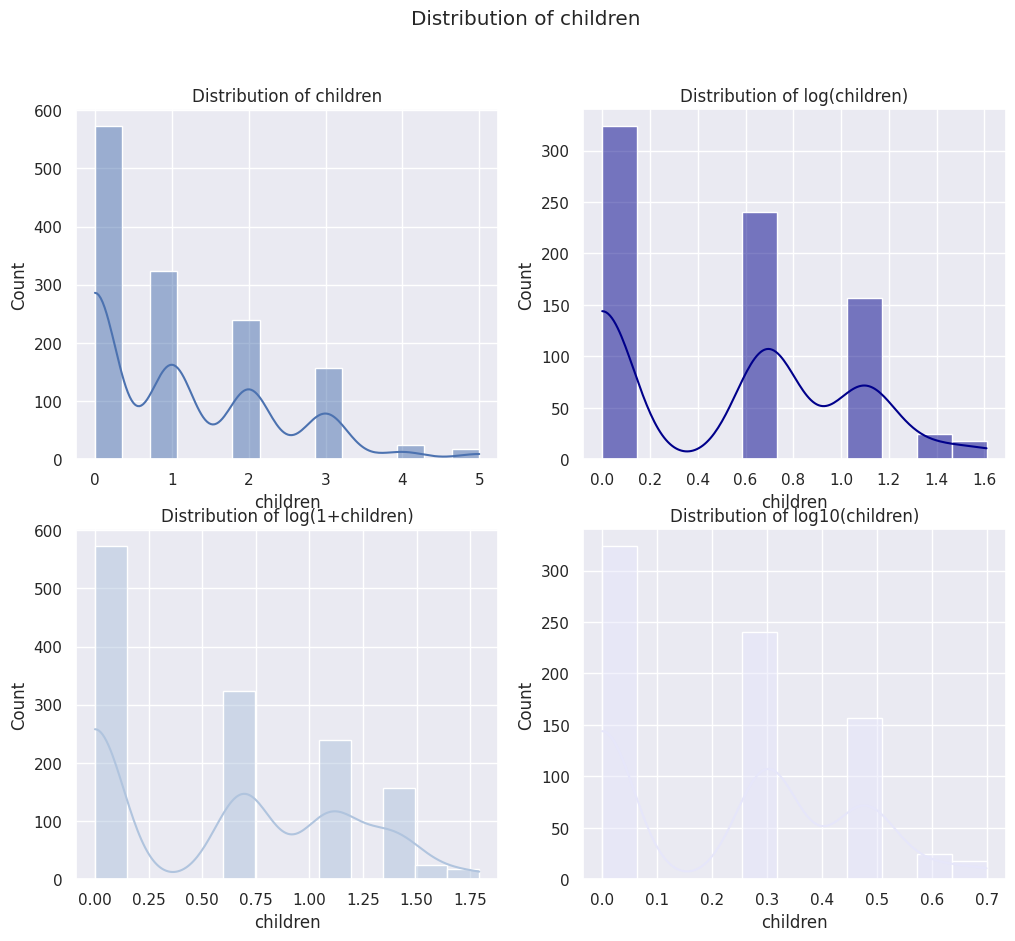

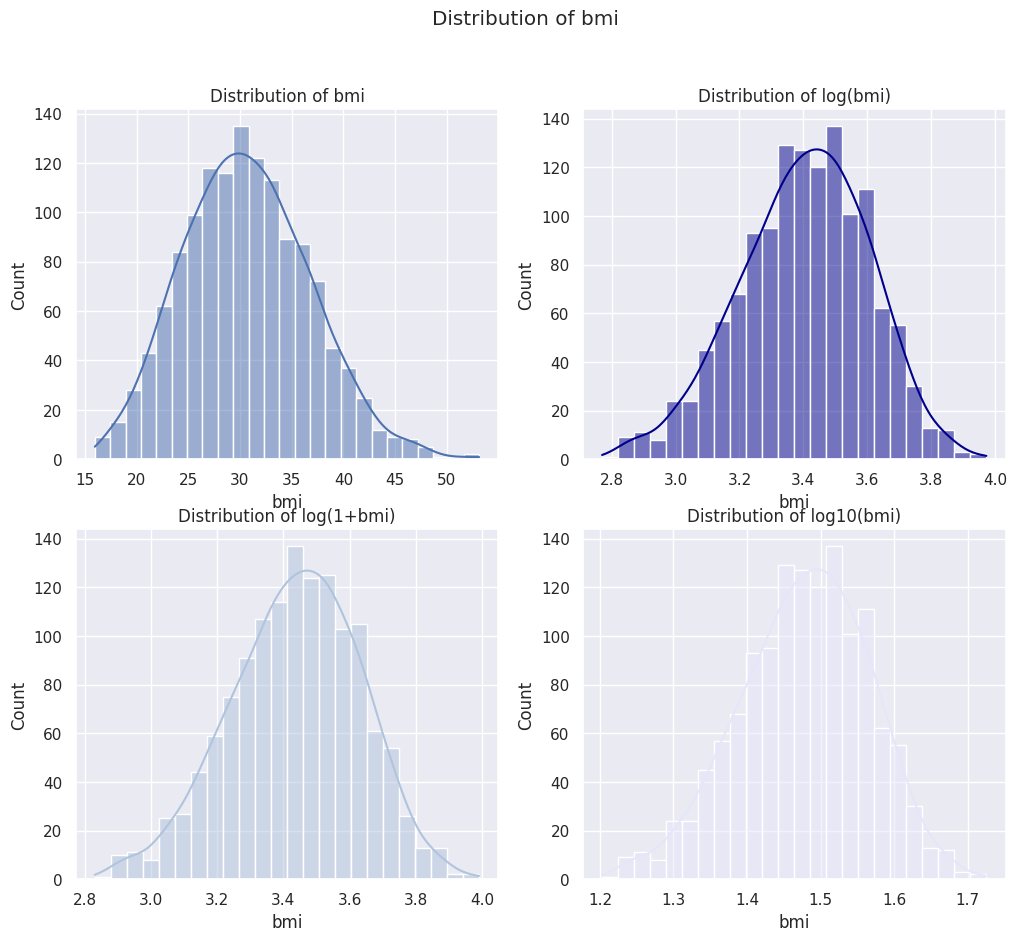

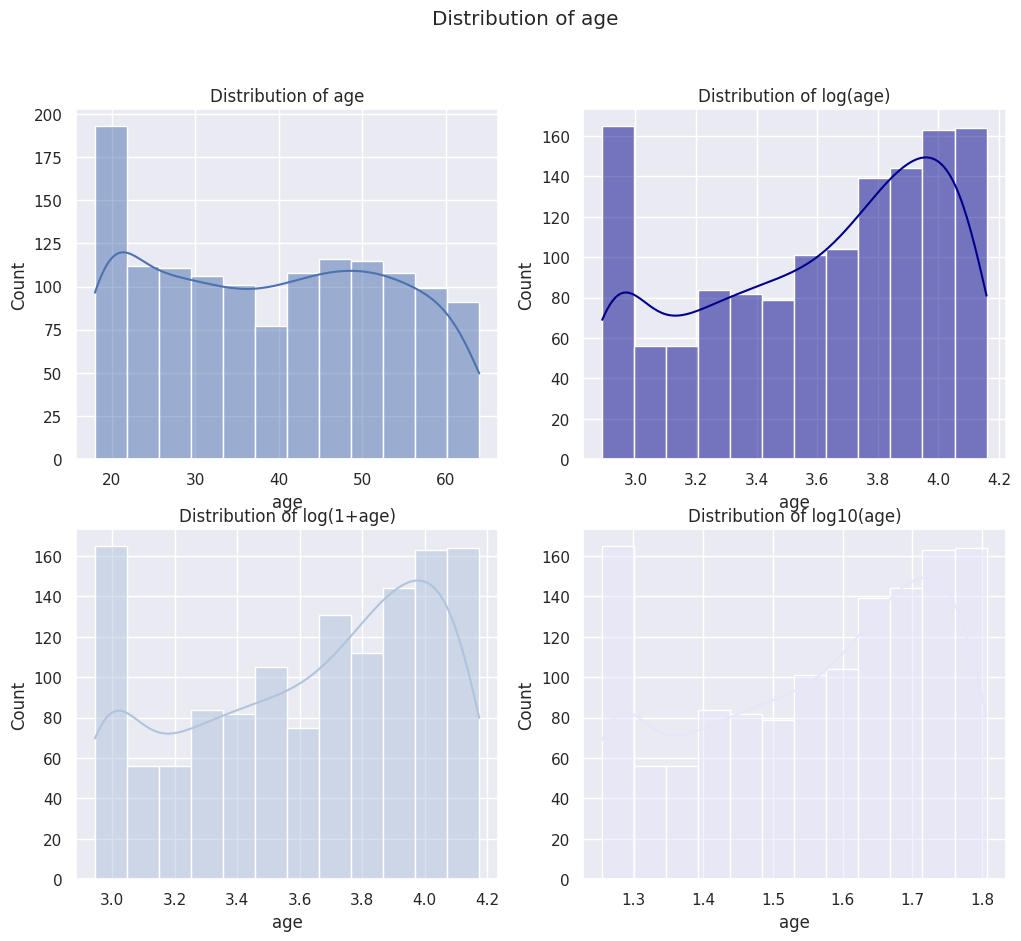

In [62]:
for i in columns:
    #Fig 2*2 sub-graph:
    fig, axes= plt.subplots(2,2, figsize=(12,10))
    fig.suptitle(f'Distribution of {i}')
    
    #Normal distribution
    sns.histplot(df[i], ax=axes[0,0], kde=True)
    axes[0,0].set_title(f'Distribution of {i}')

    #Return the natural logarithm of i, inverse of exp(i)
    log_data = np.log(df[i])
    sns.histplot(log_data,ax=axes[0,1], color='darkblue', kde=True)
    axes[0,1].set_title(f'Distribution of log({i})')

    #Return the natural logarithm of one plus the input array, element-wise.
    #the inverse of exp(x)-1
    log_1p = np.log1p(df[i])
    sns.histplot(log_1p, ax=axes[1,0], color='lightsteelblue', kde=True)
    axes[1,0].set_title(f'Distribution of log(1+{i})')

    #Return the base 10 log
    log_10 = np.log10(df[i])
    sns.histplot(log_10, ax=axes[1,1], color='lavender', kde=True)
    axes[1,1].set_title(f'Distribution of log10({i})')

    plt.show()

L'analyse des distributions des différentes variables continues nous a permi de vérifier plusieurs points. La distribution de bmi semble suivre la loi normale, tandis que les autres variables non. La transformation log des différentes variables permet de recentrer ces variables sans non plus faire des miracles ( d'autres méthodes de transformation sont disponibles et pourraient être testées). Il conviendra de tester si ces transformations permettent d'affiner le modèle de prédiction ou non.

#### Analyse des données catégorielles

In [63]:
# Définition du tableau de fréquence
columns_cat = ['sex','smoker','region']

for i in columns_cat:
    count=df[i].value_counts()
    print("Fréquence:")
    print(count)

Fréquence:
sex
male      675
female    662
Name: count, dtype: int64
Fréquence:
smoker
no     1063
yes     274
Name: count, dtype: int64
Fréquence:
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


In [64]:
# Définition du tableau de fréquence mais avec une notion de proportion
columns_cat = ['sex','smoker','region']

for i in columns_cat:
    count=df[i].value_counts(normalize=True)
    print("Fréquence:")
    print(count)

Fréquence:
sex
male      0.504862
female    0.495138
Name: proportion, dtype: float64
Fréquence:
smoker
no     0.795064
yes    0.204936
Name: proportion, dtype: float64
Fréquence:
region
southeast    0.272251
southwest    0.243082
northwest    0.242334
northeast    0.242334
Name: proportion, dtype: float64


<Axes: ylabel='count'>

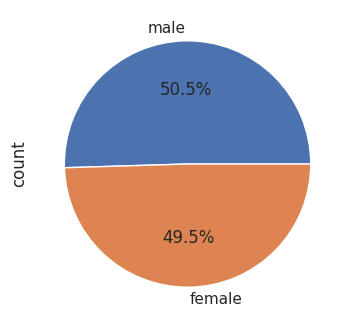

In [65]:
df['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%')
  


<Axes: ylabel='count'>

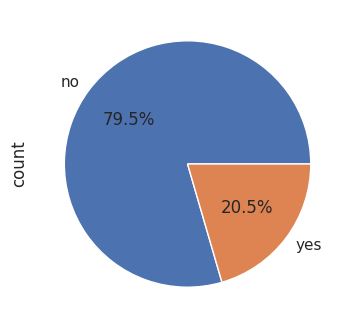

In [66]:
df['smoker'].value_counts().plot(kind='pie', autopct='%1.1f%%')


<Axes: ylabel='count'>

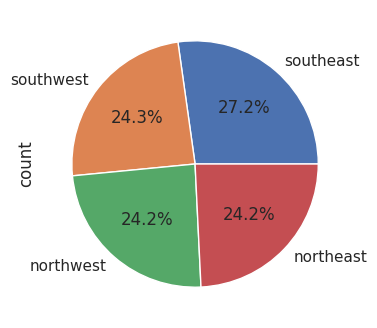

In [67]:
df['region'].value_counts().plot(kind='pie', autopct='%1.1f%%')

Cette table de fréquence nous permet d'observer que la répartition des observations hommes femmes, ainsi que la régionalité est équilibrée. En revanche la répartition des fumeurs/non fumeurs est très inégales, il y a quasiment 4 fois plus de non fumeurs. Un soin particulier sera apportée lors du split du dataset afin de respecter cette répartition dans les train et tests sets afin d'avoir des représentations équivalentes de fumeurs/ non fumeurs dans les différents sets.

# Analyse bivariée

#### Test Chi² pour vérifier si association significative entre deux variables catégorielles.
H0 = Les deux variables sont indépendantes
H1 : Les deux variables sont dépendantes
si p inférieur ou égal à 0.05, alors H0 est rejeté.

In [68]:
#Test pour le sexe et les régions
table_SR = pd.crosstab(df['sex'], df['region'])
chi2, p, dof, expected = chi2_contingency(table_SR)
print(f"Chi² : {chi2}, p-value : {p}, Degrees of Freedom : {dof}")
print(f"Effectifs attendus : \n{expected}")

Chi² : 0.476909551071918, p-value : 0.9239341965125791, Degrees of Freedom : 3
Effectifs attendus : 
[[160.42483171 160.42483171 180.23036649 160.91997008]
 [163.57516829 163.57516829 183.76963351 164.08002992]]


Les variables 'sex' et 'region' sont indépendantes

In [69]:
#Test pour le sexe et les fumeurs
table_SSm = pd.crosstab(df['sex'], df['smoker'])
chi2, p, dof, expected = chi2_contingency(table_SSm)
print(f"Chi² : {chi2}, p-value : {p}, Degrees of Freedom : {dof}")
print(f"Effectifs attendus : \n{expected}")

Chi² : 7.469139330086637, p-value : 0.0062765550120107375, Degrees of Freedom : 1
Effectifs attendus : 
[[526.33208676 135.66791324]
 [536.66791324 138.33208676]]


Il semble que les variables 'sex' et 'smoker' sont dépendantes l'une de l'autre, la p-value est de "0.00627". Voyons la répartitions dans un graphe:

<Axes: xlabel='smoker', ylabel='sex'>

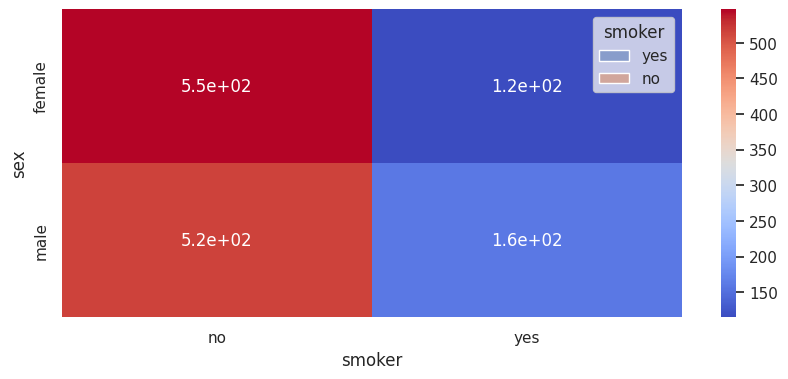

In [70]:
sns.histplot(data=df, x="sex", hue="smoker")
sns.heatmap(table_SSm, annot=True, cmap='coolwarm')

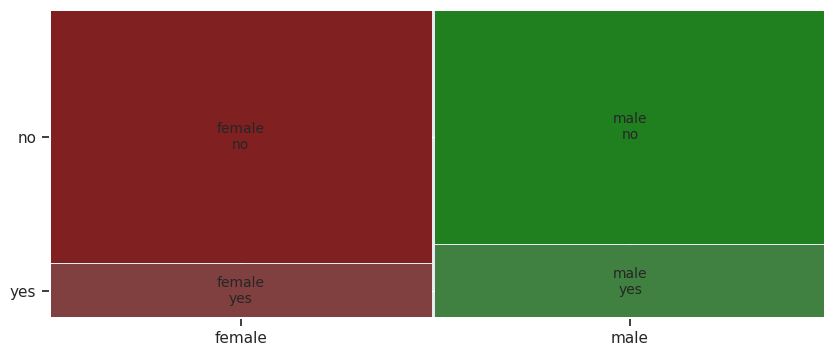

In [71]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['sex', 'smoker'])
plt.show()

A proportion équivalente, les femmes fument moins que les hommes.

In [72]:
#Test pour les régions et les fumeurs
table_RSm = pd.crosstab(df['region'], df['smoker'])
chi2, p, dof, expected = chi2_contingency(table_RSm)
print(f"Chi² : {chi2}, p-value : {p}, Degrees of Freedom : {dof}")
print(f"Effectifs attendus : \n{expected}")

Chi² : 7.27790254132191, p-value : 0.06354826573182334, Degrees of Freedom : 3
Effectifs attendus : 
[[257.60059835  66.39940165]
 [257.60059835  66.39940165]
 [289.40314136  74.59685864]
 [258.39566193  66.60433807]]


<Axes: xlabel='smoker', ylabel='region'>

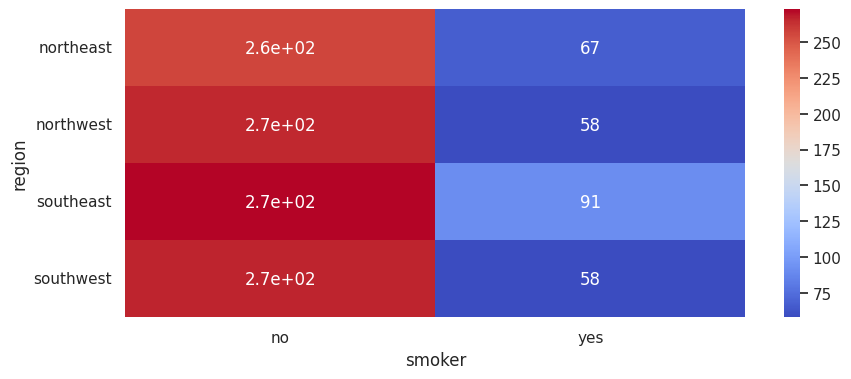

In [73]:

sns.heatmap(table_RSm, annot=True, cmap='coolwarm')

Bien qu'il semble y avoir une légère différence entre la région du sud est et les autres régions, le test Chi² montrent que les variables 'smoker' et 'region' sont indépendantes. Il pourrait être intéressant de séparer les régions et de les encoder en valeurs numériques pour plus de précisions.

#### Test Anova pour voir des relations entre les variables catégorielles et continues

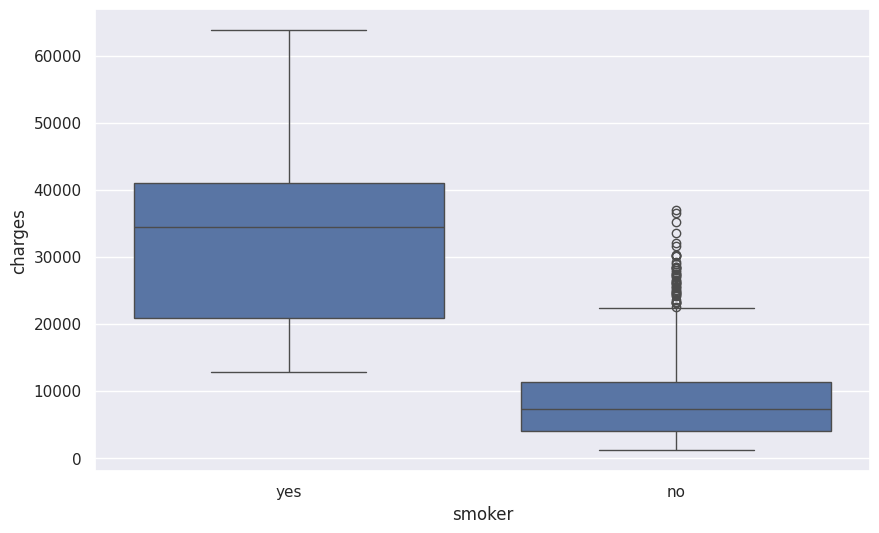

In [93]:
#Etude sur les fumeurs et les charges
plt.subplots(figsize=(10,6))
ax = sns.boxplot(y="charges", x="smoker", data=df)

Les fumeurs payent plus de charges que les non fumeurs même si une sous-classe de fumeurs payent plus(rapport avec bmi ici)

In [101]:
model = ols('charges ~ C(smoker)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(smoker),1.214307e+11,1.0,2175.736863,1.406722e-282
Residual,7.450811e+10,1335.0,NaN,NaN


In [102]:
"""
The function below was created specifically for the one-way ANOVA table results returned for Type II sum of squares
"""

def anova_test(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_test(anova_table)

/tmp/ipykernel_231563/2700473788.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(smoker),1.214307e+11,1.0,1.214307e+11,2175.736863,1.406722e-282,0.619738,0.619277
Residual,7.450811e+10,1335.0,5.581132e+07,NaN,NaN,NaN,NaN


In [107]:
for i in columns:
    for j in columns_cat:
        model = ols(f'{i}~ C({j})', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f"anova for {i}")
        print(anova_table)
        print(anova_test(anova_table))

anova for charges
                sum_sq      df         F    PR(>F)
C(sex)    6.601500e+08     1.0  4.513038  0.033821
Residual  1.952787e+11  1335.0       NaN       NaN
                sum_sq      df       mean_sq         F    PR(>F)    eta_sq  \
C(sex)    6.601500e+08     1.0  6.601500e+08  4.513038  0.033821  0.003369   
Residual  1.952787e+11  1335.0  1.462762e+08       NaN       NaN       NaN   

          omega_sq  
C(sex)    0.002621  
Residual       NaN  
anova for charges
                 sum_sq      df            F         PR(>F)
C(smoker)  1.214307e+11     1.0  2175.736863  1.406722e-282
Residual   7.450811e+10  1335.0          NaN            NaN
                 sum_sq      df       mean_sq            F         PR(>F)  \
C(smoker)  1.214307e+11     1.0  1.214307e+11  2175.736863  1.406722e-282   
Residual   7.450811e+10  1335.0  5.581132e+07          NaN            NaN   

             eta_sq  omega_sq  
C(smoker)  0.619738  0.619277  
Residual        NaN       NaN  
anova

/tmp/ipykernel_231563/2700473788.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
/tmp/ipykernel_231563/2700473788.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
/tmp/ipykernel_231563/2700473788.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

Ces tests confirment les relations entre les charges, les smokers, et le bmi. Etonnanment, il semble également y avoir un lien entre région et bmi !

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

southeast vs. northeast: t-test independent samples, P_val:1.186e-17 t=8.791e+00
southwest vs. northwest: t-test independent samples, P_val:1.058e-03 t=3.290e+00


/tmp/ipykernel_231563/593056058.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=df, x="region", y="bmi", palette='pastel')


(<Axes: xlabel='region', ylabel='bmi'>,
  <statannotations.Annotation.Annotation at 0x7fb525c6fdd0>])

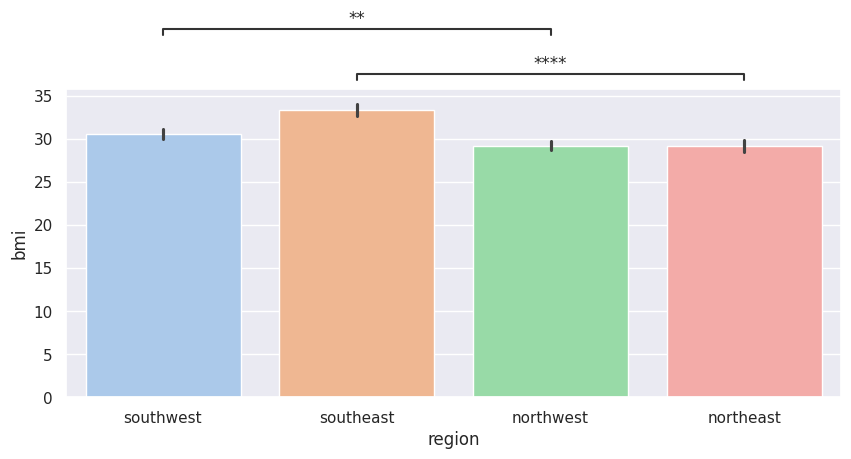

In [ ]:
#Test annotation
ax=sns.barplot(data=df, x="region", y="bmi", palette='pastel')
pairs = [("northeast", "southeast"), ("northwest", "southwest")]
annotator = Annotator(ax, pairs, data=df, x="region", y="bmi")
annotator.configure(test='t-test_ind', text_format='star', loc='outside')
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

southwest vs. southeast: t-test independent samples, P_val:5.437e-09 t=-5.908e+00
southeast vs. northwest: t-test independent samples, P_val:2.750e-19 t=9.252e+00
southeast vs. northeast: t-test independent samples, P_val:1.186e-17 t=8.791e+00


/tmp/ipykernel_231563/753545661.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=df, x="region", y="bmi", palette='pastel')


(<Axes: xlabel='region', ylabel='bmi'>,
  <statannotations.Annotation.Annotation at 0x7fb525d6c170>])

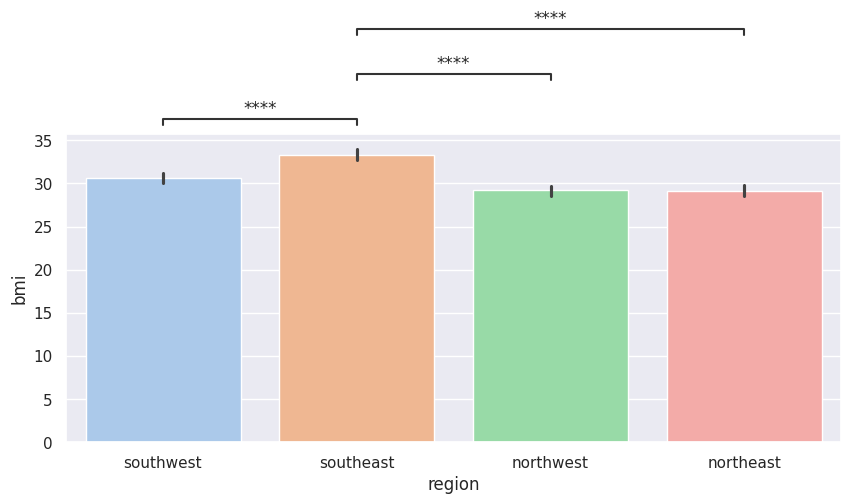

In [158]:
#comparaison southeast par rapport aux autres

ax=sns.barplot(data=df, x="region", y="bmi", palette='pastel')
target = "southeast"
pairs = [(target, region) for region in df['region'].unique() if region != target]
annotator = Annotator(ax, pairs, data=df, x="region", y="bmi")
annotator.configure(test='t-test_ind', text_format='star', loc='outside')
annotator.apply_and_annotate()

Les individus issus de la région "southeast" sont plus gros et/ou plus petit que les individus issus des autres régions

In [129]:
#visualisation des p_values

## source : https://asardell.github.io/statistique-python/
#source sur une ancienne version de python, .set_precision remplacé par .format(precision=2)


n=len(columns)
m=len(columns_cat)

#création d'une matrice vide
a=np.empty((m,n))
a[:] = np.nan

#coordonnée de PR dans la table anova : [0,-1]
for j in range(n):
    for i in range(m):
        model = ols(f'{columns[j]}~ C({columns_cat[i]})', data=df).fit()
        anova_table=sm.stats.anova_lm(model, typ=2)
        p_value=anova_table.iloc[0,-1]
        a[i,j] = p_value

df_pvalue = round(pd.DataFrame(a, columns=columns, index = columns_cat),5)

cm = sns.light_palette("green", as_cmap=True) 

df_pvalue.style.background_gradient(cmap=cm).format(precision=2)

,charges,children,bmi,age
sex,0.03,0.51,0.09,0.47
smoker,0.00,0.79,0.89,0.35
region,0.03,0.53,0.00,0.97


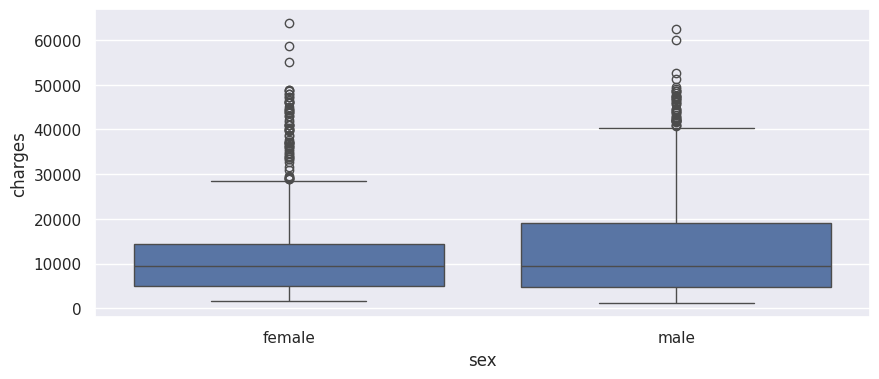

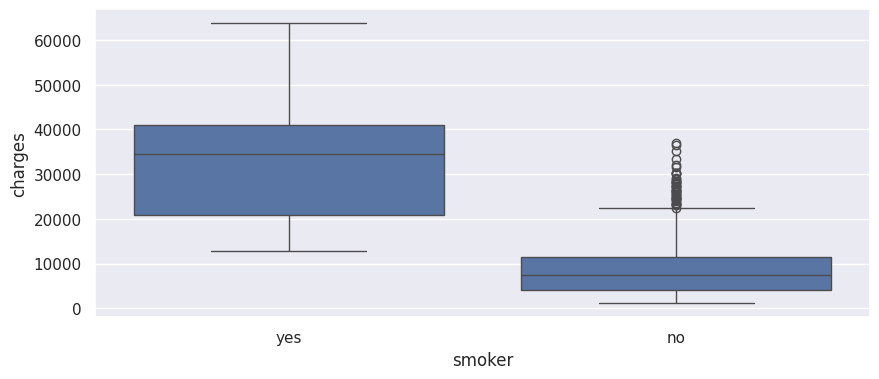

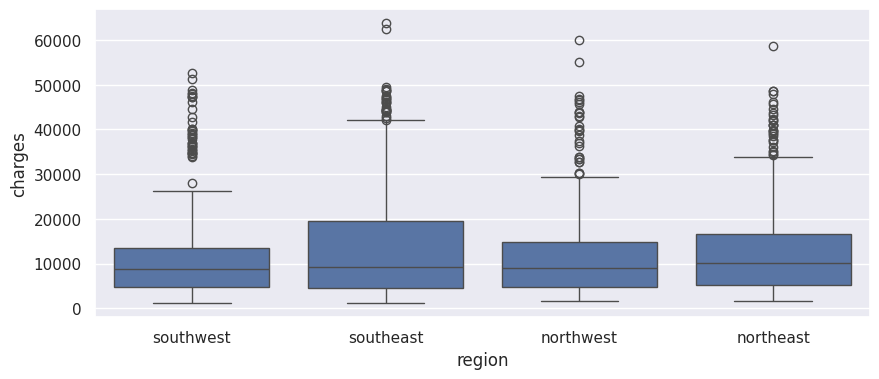

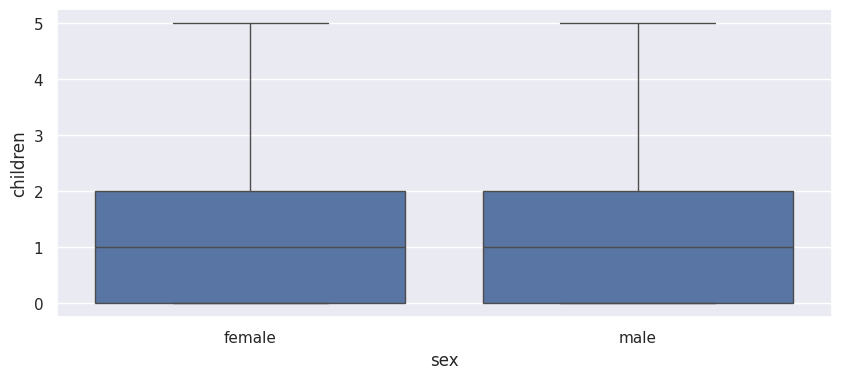

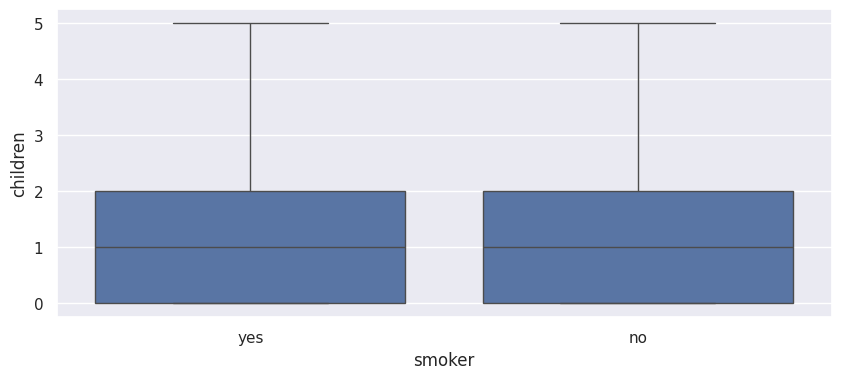

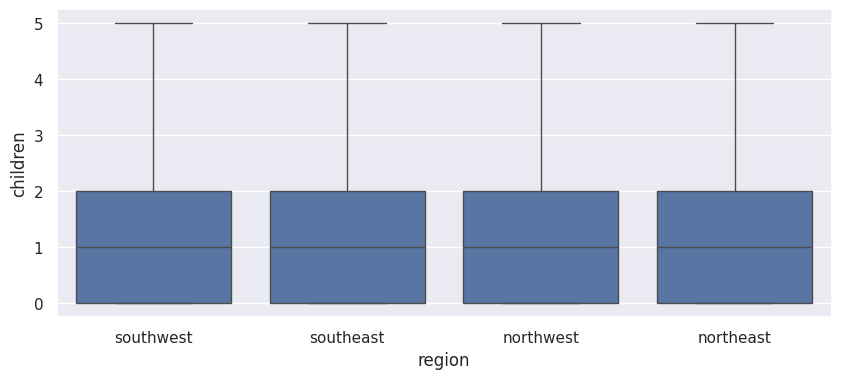

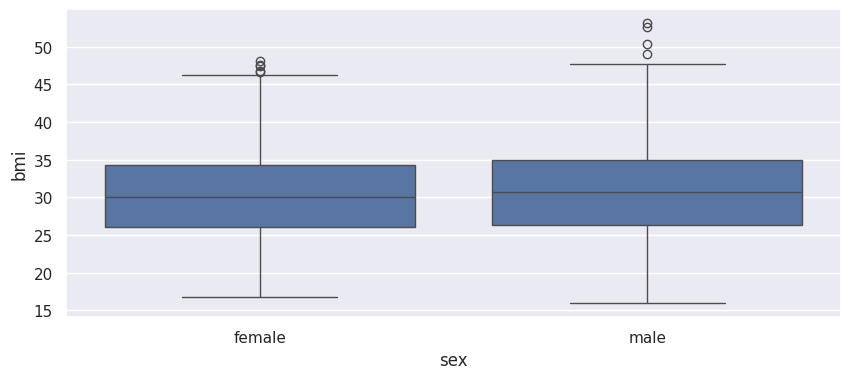

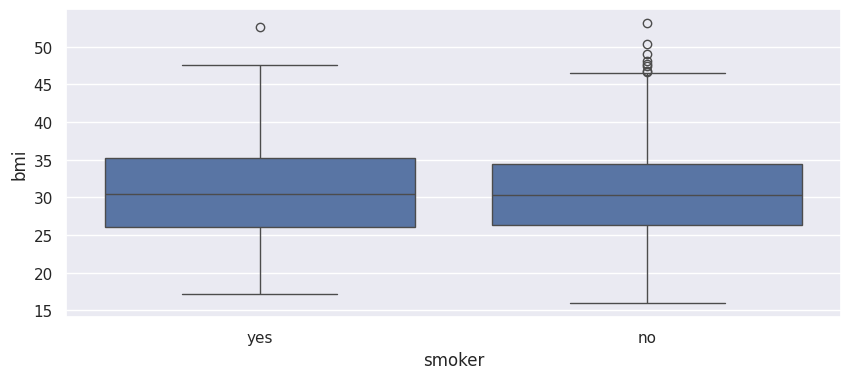

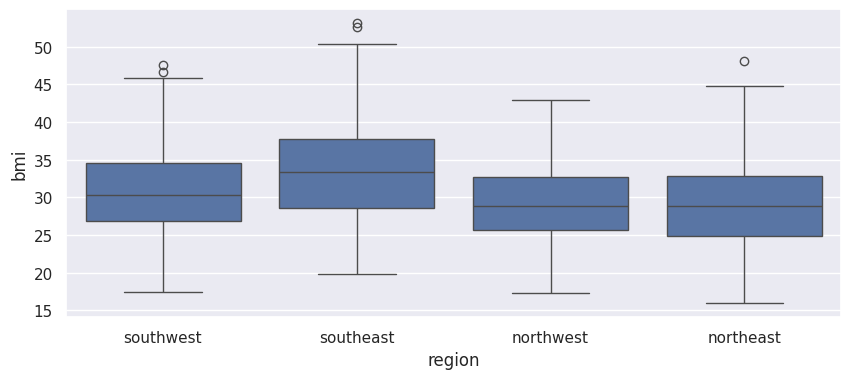

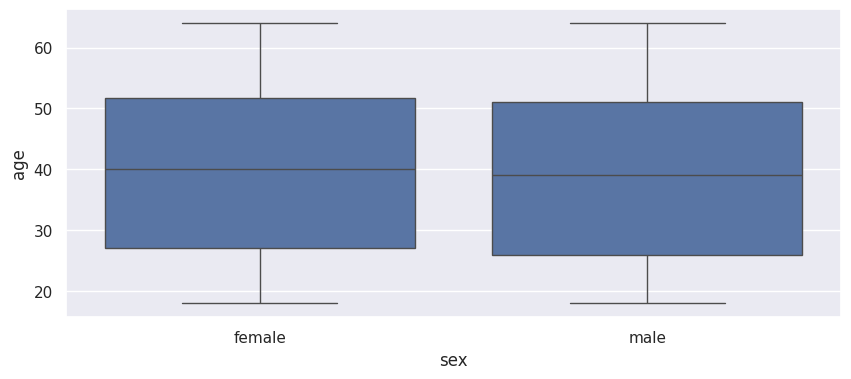

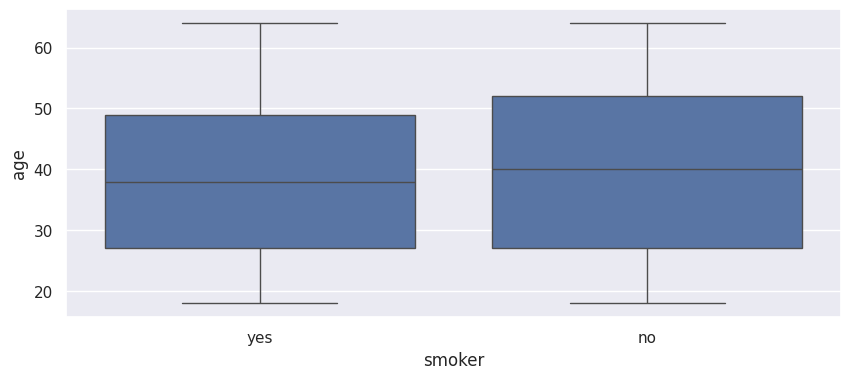

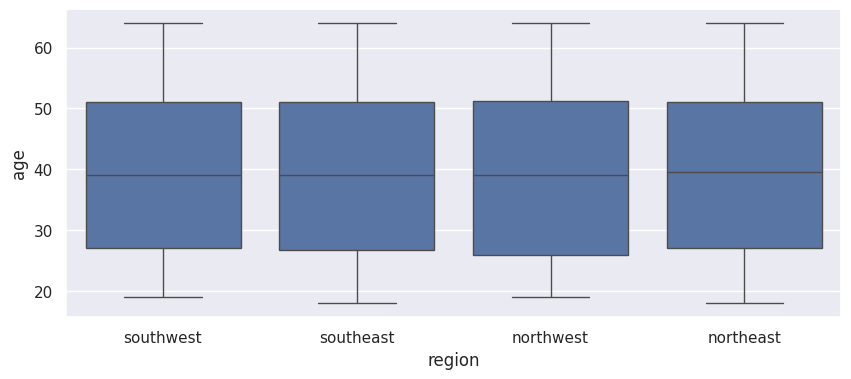

In [140]:
#Visualisation des relations entre variables catégorielles et continues
for continue_data in columns:
    for discrete_data in columns_cat:
        sns.boxplot(y=continue_data, x=discrete_data, data=df)
        plt.show()




#### Test de Pearson pour voir des corrélations entre variables continues

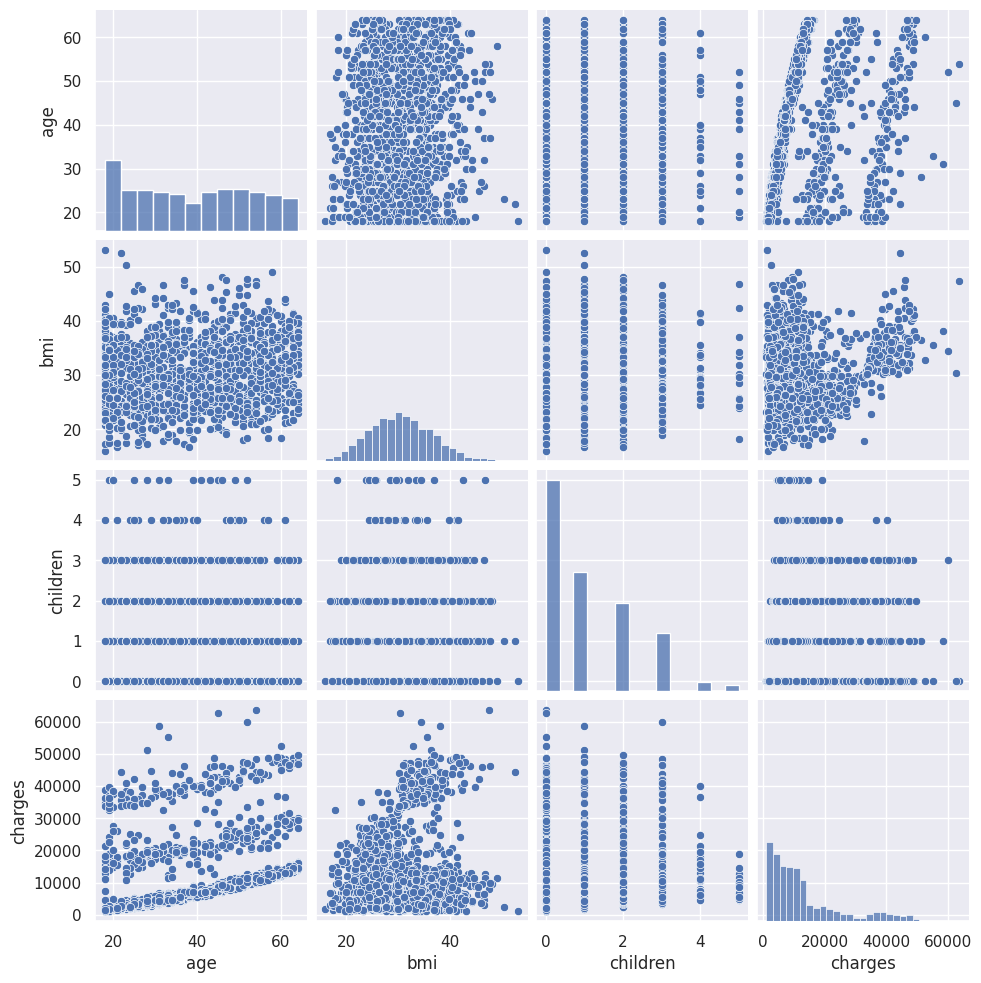

In [74]:
sns.pairplot(df)

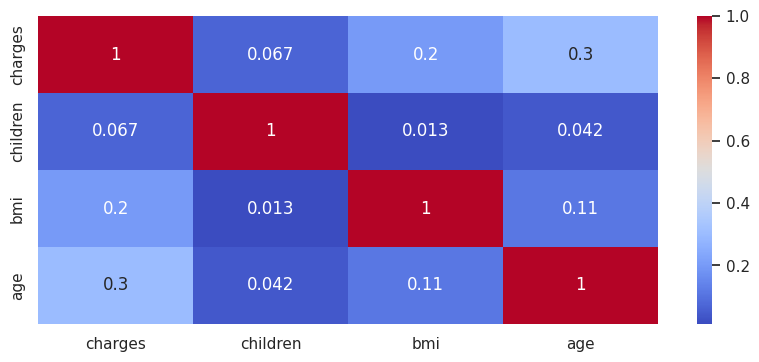

In [75]:
# Matrice de corrélation
sns.set(rc={'figure.figsize':(10,4)})
df_corr=df[columns].corr()
ax=sns.heatmap(df_corr, annot=True, cmap='coolwarm')

Bien que les résultats ne semblent pas flagrant, les résultats tendent à montrer une relation entre bmi et charges, et entre charges et age.

In [76]:
#Bmi vs charges
pearsonr(df.charges, df.bmi)

PearsonRResult(statistic=np.float64(0.19840083122624935), pvalue=np.float64(2.4680404264513685e-13))

Il semble donc y avoir une belle corrélation entre les deux variables

In [78]:
#Test des valeurs deux a deux dans une boucle

for i in columns:
    for j in columns:
       print(pearsonr(df[i], df[j]))
       

PearsonRResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.06738935083963249), pvalue=np.float64(0.013717026292987116))
PearsonRResult(statistic=np.float64(0.19840083122624935), pvalue=np.float64(2.4680404264513685e-13))
PearsonRResult(statistic=np.float64(0.29830821250978645), pvalue=np.float64(6.975748762691051e-29))
PearsonRResult(statistic=np.float64(0.06738935083963249), pvalue=np.float64(0.013717026292987116))
PearsonRResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.012754657513395232), pvalue=np.float64(0.6412463331651338))
PearsonRResult(statistic=np.float64(0.04153621001636623), pvalue=np.float64(0.12901275682640062))
PearsonRResult(statistic=np.float64(0.19840083122624935), pvalue=np.float64(2.4680404264513685e-13))
PearsonRResult(statistic=np.float64(0.012754657513395235), pvalue=np.float64(0.6412463331651338))
PearsonRResult(statistic=np.float64(0.9999999999999999), pvalue=np.float64

In [303]:
## source : https://asardell.github.io/statistique-python/
#source sur une ancienne version de python, .set_precision remplacé par .format(precision=2)

n=len(columns)

#création d'une matrice vide
a=np.empty((n,n))
a[:] = np.nan

#remplissage de la matrice vide avec les corrélations
for i in range(n):
    for j in range(n):
        coeff, p_value = pearsonr(df[columns[i]], df[columns[j]])
        print(f"Correlation entre {columns[i]} et {columns[j]}: coeff={coeff}, p={p_value}")
        a[i,j] = p_value
df_pvalue = round(pd.DataFrame(a, columns=columns, index = columns),5)

cm = sns.light_palette("green", as_cmap=True) 

df_pvalue.style.background_gradient(cmap=cm).format(precision=2)


Correlation entre charges et charges: coeff=1.0, p=0.0
Correlation entre charges et children: coeff=0.06738935083963249, p=0.013717026292987116
Correlation entre charges et bmi: coeff=0.19840083122624935, p=2.4680404264513685e-13
Correlation entre charges et age: coeff=0.29830821250978645, p=6.975748762691051e-29
Correlation entre children et charges: coeff=0.06738935083963249, p=0.013717026292987116
Correlation entre children et children: coeff=1.0, p=0.0
Correlation entre children et bmi: coeff=0.012754657513395232, p=0.6412463331651338
Correlation entre children et age: coeff=0.04153621001636623, p=0.12901275682640062
Correlation entre bmi et charges: coeff=0.19840083122624935, p=2.4680404264513685e-13
Correlation entre bmi et children: coeff=0.012754657513395235, p=0.6412463331651338
Correlation entre bmi et bmi: coeff=0.9999999999999999, p=0.0
Correlation entre bmi et age: coeff=0.10934361041896884, p=6.164372237148674e-05
Correlation entre age et charges: coeff=0.2983082125097864

,charges,children,bmi,age
charges,0.00,0.01,0.00,0.00
children,0.01,0.00,0.64,0.13
bmi,0.00,0.64,0.00,0.00
age,0.00,0.13,0.00,0.00


Il semble donc bien y avoir des corrélations entre bmi, age et charges. En revanche le nombre d'enfant semble être une variable moins influente dans nos résultats.

In [85]:
#Même test avec des valeurs log(1+p)
n=len(columns)

#création d'une matrice vide
a=np.empty((n,n))
a[:] = np.nan
df_log_1p = df[columns].apply(lambda x: np.log1p(x))
df_log_1p

#remplissage de la matrice vide avec les corrélations
for i in range(n):
    for j in range(n):
        coeff, p_value = pearsonr(df_log_1p[columns[i]], df_log_1p[columns[j]])
        print(f"Correlation entre {columns[i]} et {columns[j]}: coeff={coeff}, p={p_value}")
        a[i,j] = p_value
dflog_1p_pvalue = round(pd.DataFrame(a, columns=columns, index = columns),5)

cm = sns.light_palette("green", as_cmap=True) 

dflog_1p_pvalue.style.background_gradient(cmap=cm).format(precision=2)

Correlation entre charges et charges: coeff=1.0, p=0.0
Correlation entre charges et children: coeff=0.17061005370248125, p=3.4161432329132476e-10
Correlation entre charges et bmi: coeff=0.13809470491918724, p=3.998786709637184e-07
Correlation entre charges et age: coeff=0.5339456976832563, p=2.090998758332476e-99
Correlation entre children et charges: coeff=0.17061005370248128, p=3.4161432329132476e-10
Correlation entre children et children: coeff=0.9999999999999998, p=0.0
Correlation entre children et bmi: coeff=0.015898032145634074, p=0.5613720877157167
Correlation entre children et age: coeff=0.10048018988891569, p=0.00023328953131462142
Correlation entre bmi et charges: coeff=0.13809470491918724, p=3.998786709637184e-07
Correlation entre bmi et children: coeff=0.01589803214563407, p=0.5613720877157167
Correlation entre bmi et bmi: coeff=0.9999999999999999, p=0.0
Correlation entre bmi et age: coeff=0.10967823305699058, p=5.8504259321896036e-05
Correlation entre age et charges: coeff

,charges,children,bmi,age
charges,0.00,0.00,0.00,0.00
children,0.00,0.00,0.56,0.00
bmi,0.00,0.56,0.00,0.00
age,0.00,0.00,0.00,0.00


Les différences semblent plus marquées.

# Visualisations

<Axes: title={'center': 'Charges per age'}, xlabel='age', ylabel='charges'>

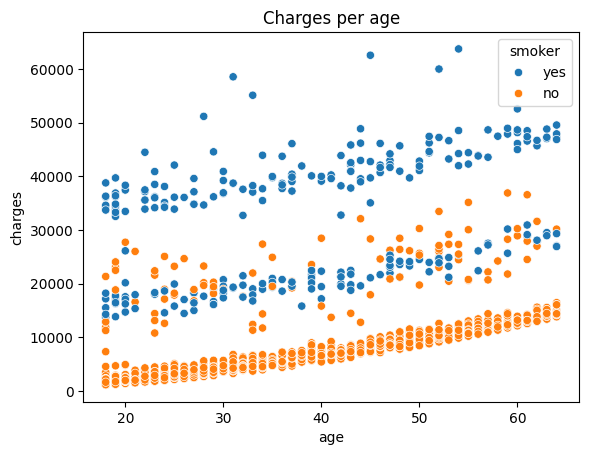

In [253]:
plt.title('Charges per age')
sns.scatterplot(x=df.age, y=df.charges, hue=df.smoker)


<Axes: title={'center': 'Charges per bmi'}, xlabel='bmi', ylabel='charges'>

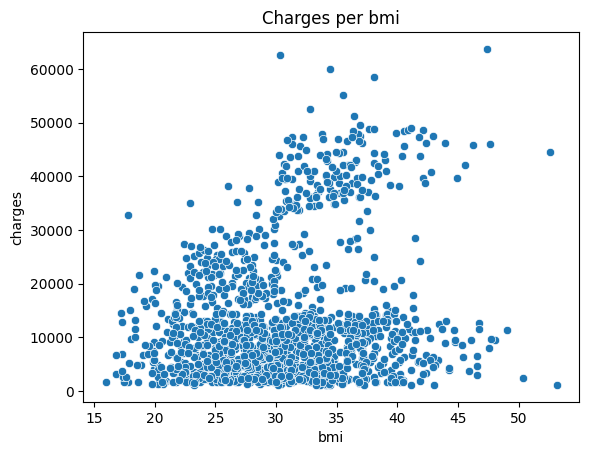

In [190]:
plt.title('Charges per bmi')
sns.scatterplot(x=df.bmi, y=df.charges)

<Axes: title={'center': 'Charges per bmi'}, xlabel='bmi', ylabel='charges'>

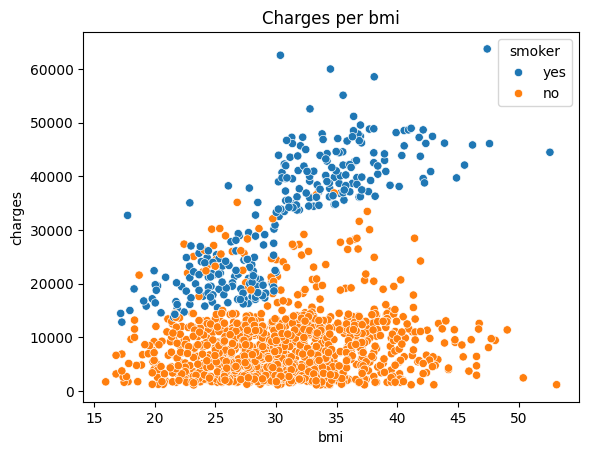

In [252]:
plt.title('Charges per bmi')
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

Les scatterplt charges/bmi en fonction des fumeurs permets d'expliquer le scatterplot charges/ages en fonction des fumeurs. En effet sur le premier on voit que les charges augmentent de façon linéaire (y=ax +b) avec l'âge, mais les variables semblent suivent 3 axes différents, qui ne varient pas selon le coefficient a de la pente mais bien selon la variable b. Les 3 groupes sont réparties comme suivant fumeurs+bmi élevé, fumeurs +bmi normal ou bmi élevé et non fumeurs, et non-fumeurs bmi normal (allant du plus cher au - cher)

/tmp/ipykernel_103347/1236225600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.smoker, y=df.charges, palette='flare')


<Axes: title={'center': 'Charges for smokers and non-smokers'}, xlabel='smoker', ylabel='charges'>

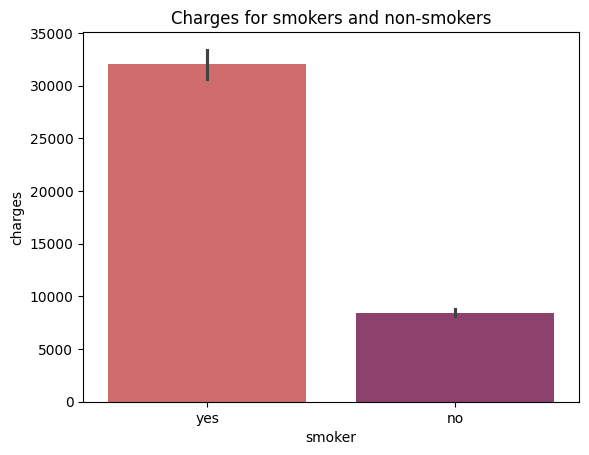

In [192]:
plt.title('Charges for smokers and non-smokers')
sns.barplot(x=df.smoker, y=df.charges, palette='flare')

/tmp/ipykernel_103347/508977280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.sex, y=df.charges, palette='pastel')


<Axes: title={'center': 'Charges for females and males'}, xlabel='sex', ylabel='charges'>

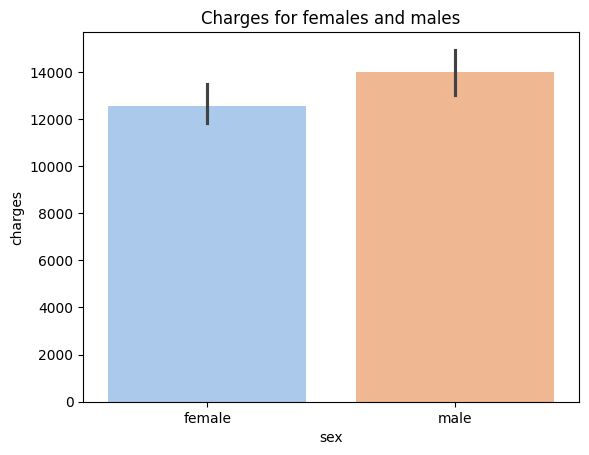

In [221]:
plt.title('Charges for females and males')
sns.barplot(x=df.sex, y=df.charges, palette='pastel')

La encore on voit la légère différence entre les hommes et les femmes concernant le montant des charges. Le fait que les hommes ait un bmi moyen légèrement plus élevé ainsi qu'une proportion plus élevé de fumeurs expliquent cette variabilité. La 'variable' sex ne semblent donc pas en soit être un pondérateur majeur de notre dataset et de notre futur modèle contrairement aux variables 'bmi' et 'smoker'

/tmp/ipykernel_231563/3664918362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.sex, y=df.bmi, palette='pastel')


<Axes: title={'center': 'Charges for females and males'}, xlabel='sex', ylabel='bmi'>

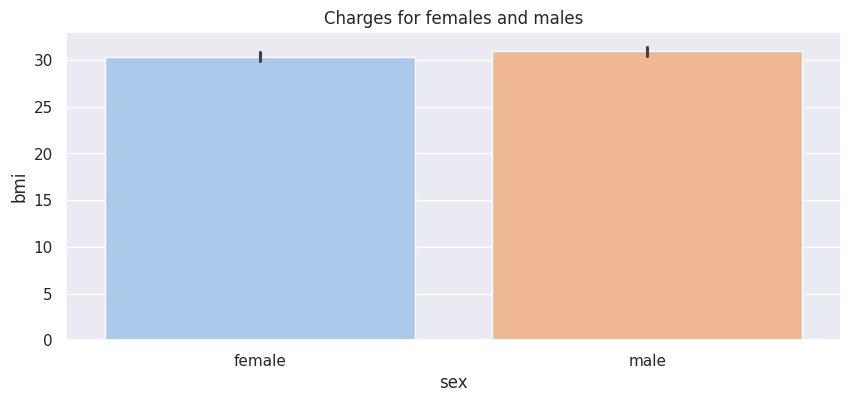

In [141]:
plt.title('Charges for females and males')
sns.barplot(x=df.sex, y=df.bmi, palette='pastel')

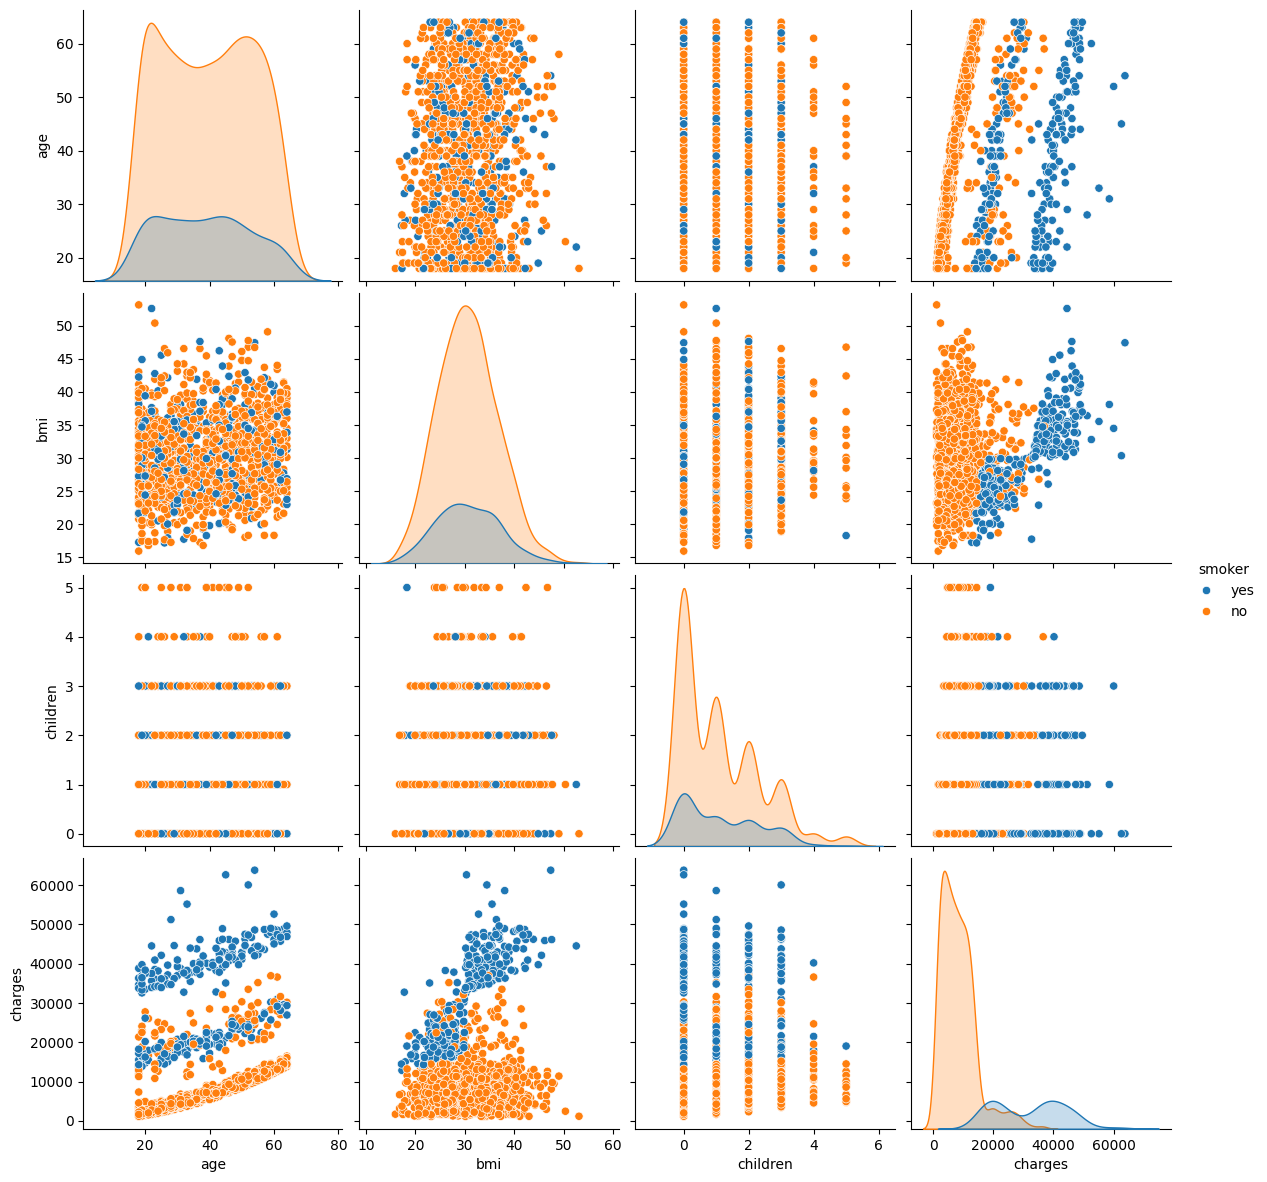

In [222]:
sns.pairplot(df, hue="smoker", height=3)

Les graphiques suivants peuvent être interprétées avec les clés suivantes :
Contours des densités :

    Les zones sombres ou les pics de densité montrent où se concentrent les données.
    Les zones claires ou plates indiquent une faible densité ou une absence de données.

Relations :

    Si les contours sont étirés ou inclinés, cela peut indiquer une relation positive ou négative entre les deux variables.
    Si les contours sont circulaires ou répartis uniformément, cela suggère une absence de relation.

Densité multiple :

    Plusieurs pics de densité peuvent suggérer des sous-groupes dans les données (par exemple, jeunes actifs vs. retraités).

Anomalies :

    Les points isolés ou des zones de densité inattendues peuvent indiquer des valeurs aberrantes.

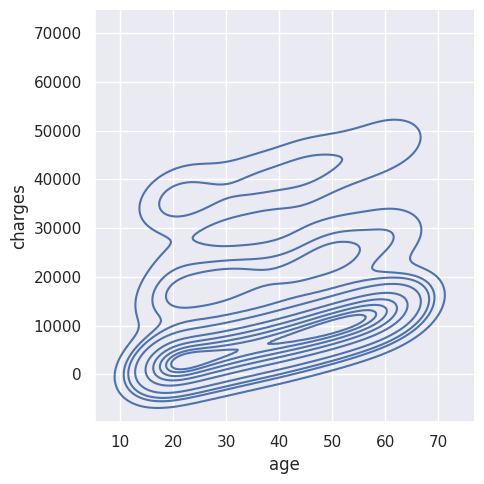

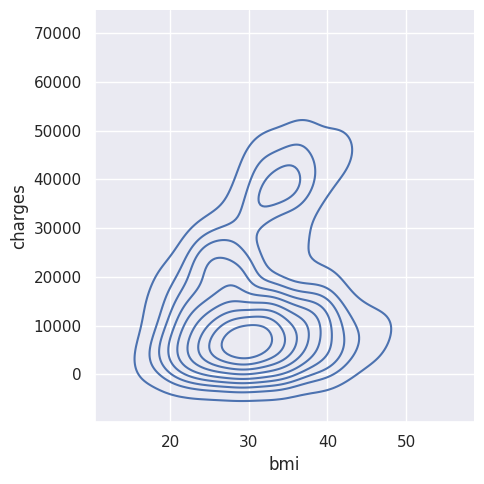

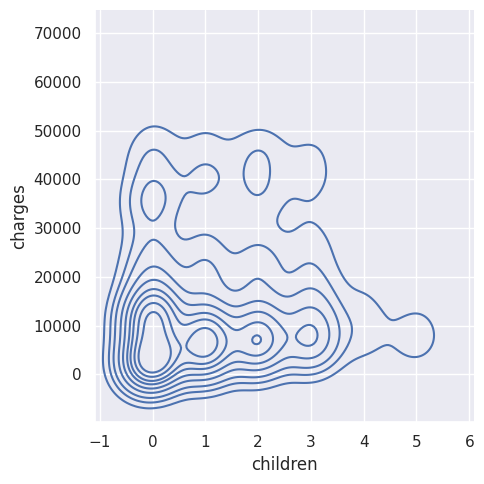

In [142]:
#analyse bivariée
sns.displot(df, x="age", y="charges", kind="kde")
sns.displot(df, x="bmi", y="charges", kind="kde")
sns.displot(df, x="children", y="charges", kind="kde")

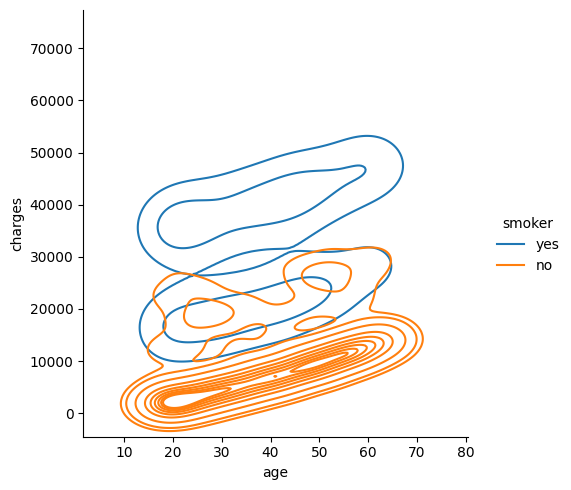

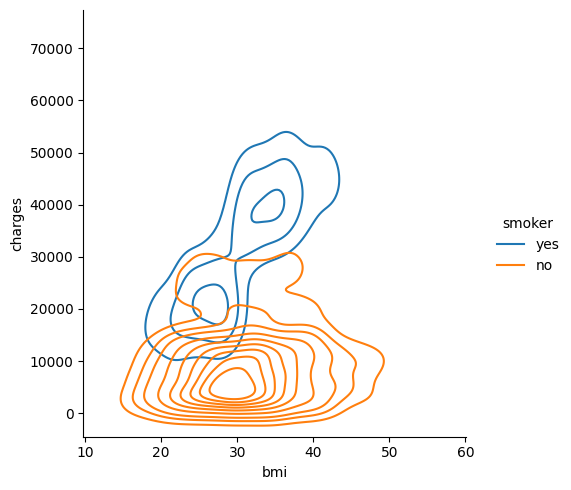

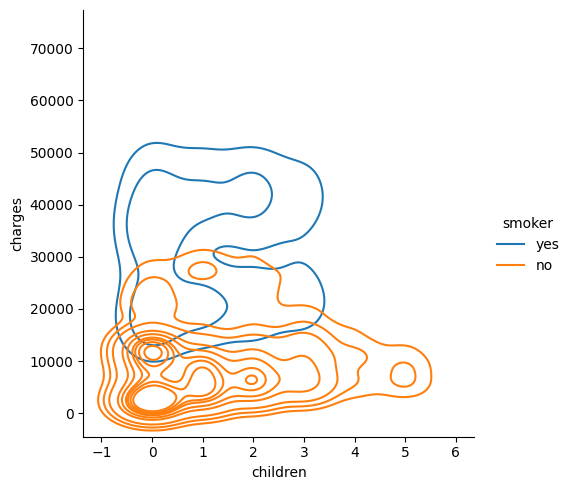

In [201]:
#analyse bivariée fonction des fumeurs et non fumeurs
sns.displot(df, x="age", y="charges", kind="kde", hue="smoker")
sns.displot(df, x="bmi", y="charges", kind="kde", hue="smoker")
sns.displot(df, x="children", y="charges", kind="kde", hue="smoker")

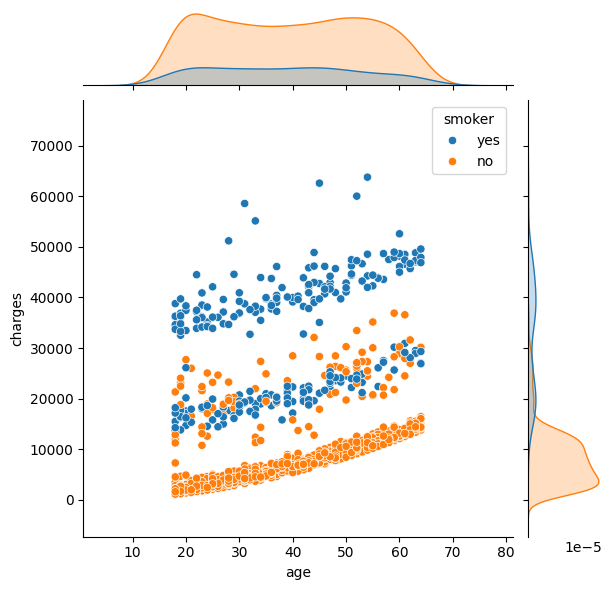

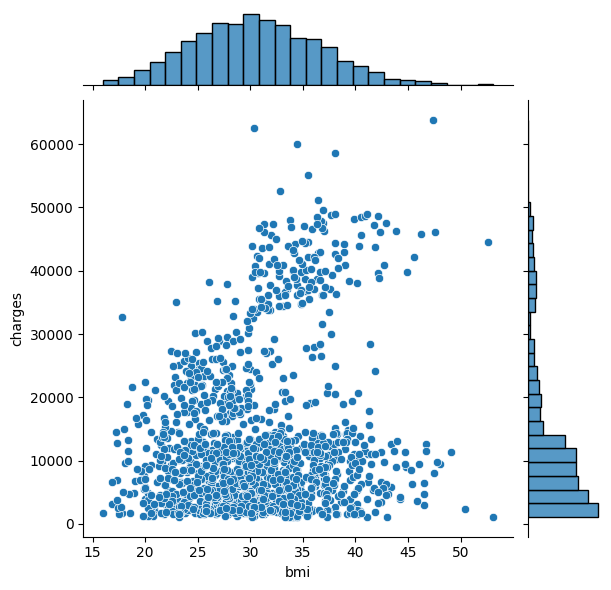

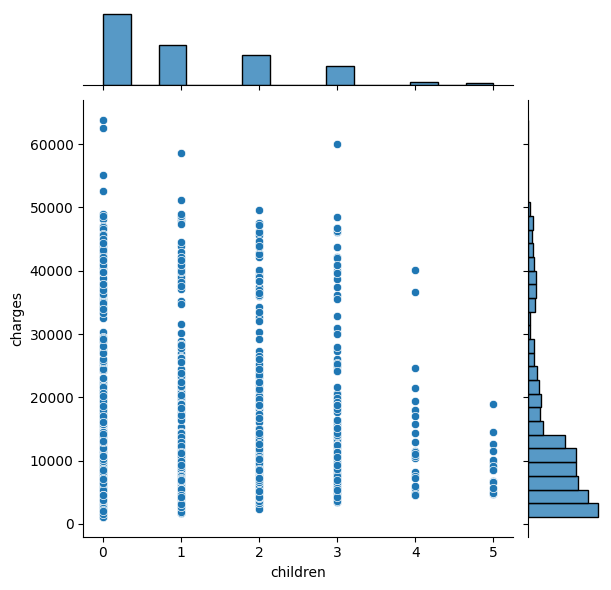

In [202]:
#plotting joint and marginal distributions
sns.jointplot(data=df, x="age", y="charges", hue="smoker")
sns.jointplot(data=df, x="bmi", y="charges")
sns.jointplot(data=df, x="children", y="charges")

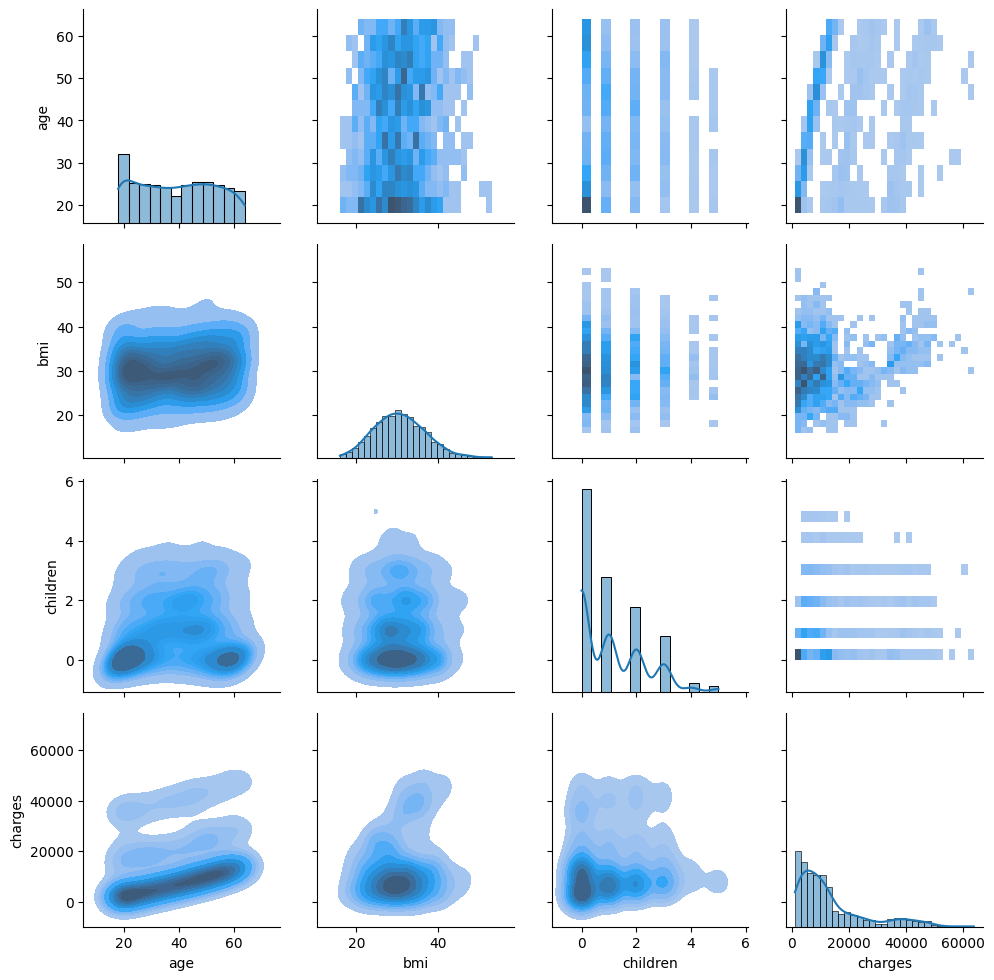

In [204]:
g=sns.PairGrid(df)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

#### Utilisation de Violinplot

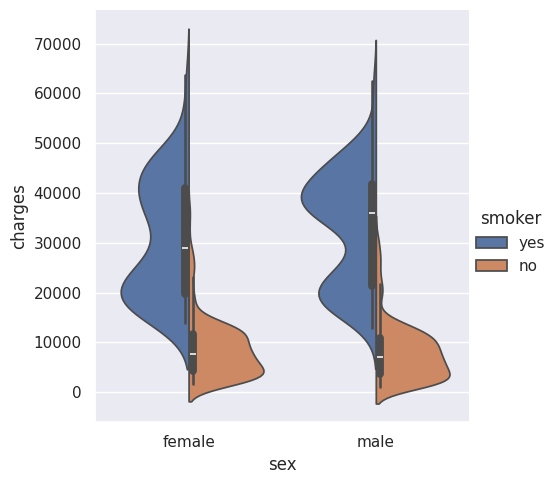

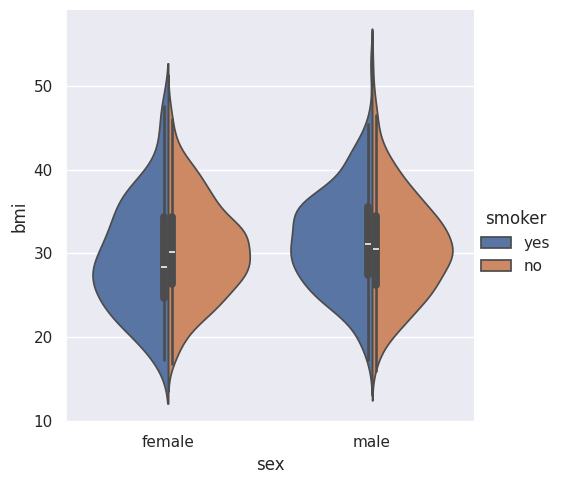

In [144]:
sns.catplot(data=df, x="sex", y="charges", hue="smoker", kind="violin", split=True)
sns.catplot(data=df, x="sex", y="bmi", hue="smoker", kind="violin", split=True)

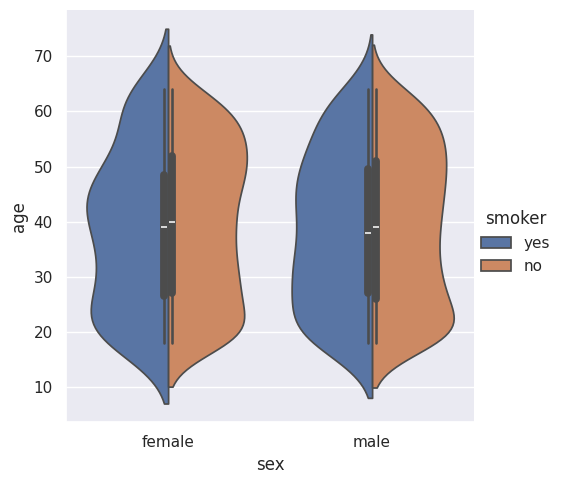

In [145]:
sns.catplot(data=df, x="sex", y="age", hue="smoker", kind="violin", split=True)

In [161]:
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)


ValueError: could not convert string to float: 'female'

In [166]:
df.to_csv("cleansed_data.csv", index=False)